# core

> Contains the main flow. Original single notebook broken up into about 10 notebooks, each of which becomes a python model.

In [1]:
#| default_exp core

In [2]:
!which python

/Users/kobus/aishiftscheduler/.venv/bin/python


In [3]:
!python --version

Python 3.10.0


In [4]:
# Set up autoreload
%load_ext autoreload
%autoreload 2

In [5]:
#| hide
from nbdev.showdoc import *

## 0 INTRODUCTION

In the previous part we found that the agent  exploited the situation by having `thCumShifts` and `thSickProb` near their max values so that it can use the complete pool. So, instead of using thresholds below which resources are included as candidates, we always had all (available) resources in the candidates pool. The agent earned rewards or incurred penalties to discourage allocation of less ideal resources. The had the parameters:

- $\theta^{CumShifts}$
- $\theta^{SickProb}$

Each of these operated as weighting factors to weigh the associated component of the cumulative reward $C^{cum}$:

$C^{cum} = \theta^{CumShifts}.C^{cum}_{CumShifts} + \theta^{SickProb}.C^{cum}_{SickProb}$

In this part we add one more weighting parameters so that we now have:

- $\theta^{CumShifts}$
- $\theta^{SickProb}$
- $\theta^{CumMerits}$

The cumulative reward is now calculated:
$C^{cum} = \theta^{CumShifts}.C^{cum}_{CumShifts} + \theta^{SickProb}.C^{cum}_{SickProb} + \theta^{CumMerits}.C^{cum}_{CumMerits}$

In addition, we add a fourth (categorical) parameter called $\theta^{Select}$ which can have one of two values:

- 'random'
- 'ranked_CumMerits'

Once the list of available candidates are identified this list is either randomized ('random'), or it is ranked by the resources' cumulative merits ('ranked_CumMerits').

To keep the visualizations manageable, we will still only have the resources:

- Courtesy Clerk (7 resources)
- Stocker (3 resources)

In a later part we will also add:

- Cleaner (2 resources)
- Curbsider (4 resources)

Daily demands are provided by a stochastic demand simulator based on past needs and trends. We also add a merit simulator.

The overall *structure* of this project and report follows the traditional CRISP-DM format. However, instead of the CRISP-DM'S "4 Modeling" section, we inserted the "6 step modeling process" of [Dr. Warren Powell](https://castlelab.princeton.edu/people/) in section 4 of this document. Dr Powell's universal framework shows great promise for unifying the formalisms of at least a dozen different fields. Using his framework enables easier access to thinking patterns in these other fields that might be beneficial and informative to the sequential decision problem at hand. Traditionally, this kind of problem would be approached from the *reinforcement learning* perspective. However, using Dr. Powell's wider and more comprehensive perspective almost certainly provides additional value.

Here is information on Dr. Powell's perspective on [Sequential Decision Analytics](https://castlelab.princeton.edu/sda).

In order to make a strong mapping between the code in this notebook and the mathematics in the Powell Universal Framework (PUF), we follow the following convention for naming Python identifier names:

- How to read/say
  - var name & flavor first
  - at t/n
  - for entity OR of/with attribute
  - $\hat{R}^{fail}_{t+1,a}$ has code `Rhat__fail_tt1_a` which is read: "Rhatfail at t+1 of/with (attribute) a"
- Superscripts
  - variable names have a *double* underscore to indicate a superscript
  - $X^{\pi}$: has code `X__pi`, is read *X pi*
  - when there is a 'natural' distinction between the variable symbol and the superscript (e.g. a change in case), the double underscore is sometimes omitted: `Xpi` instead of `X__pi`, or `MSpend_t` instead of `M__Spend_t`
- Subscripts
  - variable names have a *single* underscore to indicate a subscript
  - $S_t$: has code `S_t`, is read 'S at t'
  - $M^{Spend}_t$ has code `M__Spend_t` which is read: "MSpend at t"
  - $\hat{R}^{fail}_{t+1,a}$ has code `Rhat__fail_tt1_a` which is read: "Rhatfail at t+1 of/with (attribute) a" [RLSO-p436]
- Arguments
  - collection variable names may have argument information added
  - $X^{\pi}(S_t)$: has code `X__piIS_tI`, is read 'X pi in S at t'
  - the surrounding `I`'s are used to imitate the parentheses around the argument
- Next time/iteration
  - variable names that indicate one step in the future are quite common
  - $R_{t+1}$: has code `R_tt1`, is read 'R at t+1'
  - $R^{n+1}$: has code `R__nt1`, is read 'R at n+1'
- Rewards
  - State-independent terminal reward and cumulative reward
    - $F$: has code `F` for terminal reward
    - $\sum_{n}F$: has code `cumF` for cumulative reward
  - State-dependent terminal reward and cumulative reward
    - $C$: has code `C` for terminal reward
    - $\sum_{t}C$: has code `cumC` for cumulative reward
- Vectors where components use different names
  - $S_t(R_t, p_t)$: has code `S_t.R_t` and `S_t.p_t`, is read 'S at t in R at t, and, S at t in p at t'
  - the code implementation is by means of a named tuple
    - `self.State = namedtuple('State', SVarNames)` for the 'class' of the vector
    - `self.S_t` for the 'instance' of the vector
- Vectors where components reuse names
  - $x_t(x_{t,GB}, x_{t,BL})$: has code `x_t.x_t_GB` and `x_t.x_t_BL`, is read 'x at t in x at t for GB, and, x at t in x at t for BL'
  - the code implementation is by means of a named tuple
    - `self.Decision = namedtuple('Decision', xVarNames)` for the 'class' of the vector
    - `self.x_t` for the 'instance' of the vector
- Use of mixed-case variable names
  - to reduce confusion, sometimes the use of *mixed-case* variable names are preferred (even though it is not a best practice in the Python community), reserving the use of underscores and double underscores for math-related variables

## 1 BUSINESS UNDERSTANDING

The HR manager has to schedule resources for each day. This schedule will be automated and optimized by the AI agent.

The number of resources of each type for each schedule slots for each day will be provided by the simulator. Only two resource types will be handled:

- Courtesy
- Stocker

The HR manager typically runs the AI Shift Scheduler 2 weeks into the future to produce a tentative schedule to publish for the team.

As demands for shift slot allocations come in, they are handled in the following way:

- the candidates for the resource type must have their:
  - $R^{Avail}_t$ be True

- the specific resources are then marked for allocation considering the number of resources needed for the type
- the state of the resources are then updated including the number of accumulated shifts
- at the end of the shift all resources are made available again

The overall objective will be to maximize the cumulative reward.

## 2 DATA UNDERSTANDING

Based on recent market research, the demand may be modeled by a Poisson distribution for each resource type:
$$
\begin{aligned}
\mu^{ResourceType} &= \mathrm{SIM\_MU\_D[RESOURCE\_TYPE]}
\end{aligned}
$$

So we have:
$$
D^{ResourceType}_{t+1} \sim Pois(\mu^{ResourceType})
$$

For each decision window, a `MeritProb` and `DemeritProb` unique to each resource is used to simulate whether that resource earned a merit (+1) and/or demerit (-1). The two values are summed to get a net merit. These merit values are also accumulated.

The decision window is 1 day and these simulations are for the daily demands for Shift1.

In [8]:
#| hide
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# root_dir = "/content/gdrive/My Drive"
# # base_dir = root_dir + '/Powell/SD.I_Inventory_Problems/InventoryStorage'
# base_dir = root_dir + '/Powell/SD.CRA_Complex_Resource_Allocation_Problems/Scheduling'

In [9]:
# don't export, else will run each time this module is loaded; just for dev
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import copy
import time
import math
from pprint import pprint
import ray
import json
from io import StringIO
import aishiftscheduler.loader as ldr
import aishiftscheduler.config as cf
import aishiftscheduler.visualization as vis
import aishiftscheduler.model as mod
import aishiftscheduler.policy as pol
import aishiftscheduler.inferencer as inf
import aishiftscheduler.trainer as trn
import aishiftscheduler.evaluator as evl
import aishiftscheduler.parameters as par
import aishiftscheduler.utils as utl
from PIL import Image

/Users/kobus/aishiftscheduler/aishiftscheduler/shift_scheduler_data.xlsx
/Users/kobus/aishiftscheduler/aishiftscheduler/AIShiftScheduler1.png

len(thNAMES)=5
thNAMES=['thCumSlots', 'thSickProb', 'thCumMerits', 'thContSlots', 'thSelect']


In [10]:
np.__version__, pd.__version__, mpl.__version__, ray.__version__, json.__version__

('1.26.4', '2.0.3', '3.8.3', '2.9.3', '2.0.9')

In [11]:
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [12]:
# check some config

In [13]:
cf.EXOG_INFO.head()

,Date,DOW,DOW_name,QOD,HOD,BOD,A_0,A_1,A_2,A_3,A_4,A_5,A_6,A_7,A_8,A_9,A_10,A_11,A_12,D_0,D_1,D_2,M_0,M_1,M_2,M_3,M_4,M_5,M_6,M_7,M_8,M_9,M_10,M_11,M_12,busyness,volume,revenue
0,2023-12-04 00:00:00,0,2023-12-04 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0000
1,2023-12-04 00:15:00,0,2023-12-04 00:15:00,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,-1,1,0,0,0,NaN,NaN
2,2023-12-04 00:30:00,0,2023-12-04 00:30:00,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,1,-1,0,0,-1,-1,0,NaN,NaN
3,2023-12-04 00:45:00,0,2023-12-04 00:45:00,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1,0,0,0,0,-1,0,0,-1,-1,0,NaN,NaN
4,2023-12-04 01:00:00,0,2023-12-04 01:00:00,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,-1,0,0,-1,-1,0,0,0.0000


In [14]:
#| hide
## forward-fill in case of coarser time resolution; MAY NOT BE NECESSARY
## cols = ['volume', 'revenue'] ##don't ffill, just set NaNs to 0
## cols = ['busyness']
## EXOG_INFO.loc[:,cols] = EXOG_INFO.loc[:,cols].ffill()

## handle NaNs in case of coarser time resolution; MAY NOT BE NECESSARY
## cols = ['volume', 'revenue']
## EXOG_INFO[cols] = EXOG_INFO[cols].fillna(0) 

In [15]:
cf.MAX_RESOURCE_TYPES

3

In [16]:
cf.MAX_RESOURCE_IDS

13

In [17]:
Pars = par.Parameters()


len(self.RESOURCE_TYPES)=3
['Manager', 'AssistMngr', 'RetailAssoc']

len(self.TYPES)=13
['Manager', 'AssistMngr', 'AssistMngr', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc', 'RetailAssoc']
len(self.aNAMES)=13
['Manager_Matt', 'AssistMngr_Mike', 'AssistMngr_Tanner', 'RetailAssoc_Jake', 'RetailAssoc_James', 'RetailAssoc_Jane', 'RetailAssoc_John', 'RetailAssoc_Jim', 'RetailAssoc_Jenny', 'RetailAssoc_Jeremy', 'RetailAssoc_Judy', 'RetailAssoc_Julie', 'RetailAssoc_Jeffrey']

len(self.bNAMES)=3
['Manager', 'AssistMngr', 'RetailAssoc']

len(self.abNAMES)=13
['Manager_Matt___Manager', 'AssistMngr_Mike___AssistMngr', 'AssistMngr_Tanner___AssistMngr', 'RetailAssoc_Jake___RetailAssoc', 'RetailAssoc_James___RetailAssoc', 'RetailAssoc_Jane___RetailAssoc', 'RetailAssoc_John___RetailAssoc', 'RetailAssoc_Jim___RetailAssoc', 'RetailAssoc_Jenny___RetailAssoc', 'RetailAssoc_Jeremy___RetailAssoc', 'RetailAssoc_Judy___

In [18]:
Pars.aNAMES

['Manager_Matt',
 'AssistMngr_Mike',
 'AssistMngr_Tanner',
 'RetailAssoc_Jake',
 'RetailAssoc_James',
 'RetailAssoc_Jane',
 'RetailAssoc_John',
 'RetailAssoc_Jim',
 'RetailAssoc_Jenny',
 'RetailAssoc_Jeremy',
 'RetailAssoc_Judy',
 'RetailAssoc_Julie',
 'RetailAssoc_Jeffrey']

In [19]:
Pars.bNAMES

['Manager', 'AssistMngr', 'RetailAssoc']

In [20]:
Pars.abNAMES

['Manager_Matt___Manager',
 'AssistMngr_Mike___AssistMngr',
 'AssistMngr_Tanner___AssistMngr',
 'RetailAssoc_Jake___RetailAssoc',
 'RetailAssoc_James___RetailAssoc',
 'RetailAssoc_Jane___RetailAssoc',
 'RetailAssoc_John___RetailAssoc',
 'RetailAssoc_Jim___RetailAssoc',
 'RetailAssoc_Jenny___RetailAssoc',
 'RetailAssoc_Jeremy___RetailAssoc',
 'RetailAssoc_Judy___RetailAssoc',
 'RetailAssoc_Julie___RetailAssoc',
 'RetailAssoc_Jeffrey___RetailAssoc']

In [21]:
#| hide
# Pars.LABELS

### Acquire 'popular times' data

In [22]:
#| hide
## generate/update 'popular times' data
# if the busyness data exists in shift_scheduler_data.xlsx,
    # delete the data
    # move the heading(s) for popular times up higher (temporarily)
# https://outscraper.com/pricing/
    # seems like I can use this approach for one-of queries
    # I did signup, but did not provide any credit card info
# click on free plan
# fill out as in outscraper_query_example.png
# submit the query
# goto 'Tasks' in left panel //https://app.outscraper.com/tasks
# download the results
# open the excel file
# goto the 'popular_times' column
# copy the value from this column to the right of the '=' in the next cell
# goto the 'place_id' column and copy its value
    # optional, maybe handy in future, when the popular times have to be updated,
    # to query by this number, however, would need a google api key:
        # ! curl -X POST -d '{"textQuery" : "Spicy Vegetarian Food in Sydney, Australia"}' \
        # -H 'Content-Type: application/json' -H 'X-Goog-Api-Key: API_KEY' \
        # -H 'X-Goog-FieldMask: places.id,places.displayName,places.formattedAddress' \
        # 'https://places.googleapis.com/v1/places:searchText'    
# run the rest of this section until PopularTimes.xlsx has been saved
# copy the 3 columns from PopularTimes.xlsx and paste into the ExogInfo2 tab of 
    # shift_scheduler_data.xlsx
# make sure the alignment is good
# delete the 'hour' and 'day' columns from the paste
# rename the 'percentage' column to 'busyness'
# load the exog info again

In [23]:
#| hide
## data_popular_times = [{"day": 7, "popular_times": [{"hour": 6, "percentage": 0, "title": "", "time": "6am"}, {"hour": 7, "percentage": 0, "title": "", "time": "6am"}, {"hour": 8, "percentage": 0, "title": "", "time": "6am"}, {"hour": 9, "percentage": 0, "title": "", "time": "9am"}, {"hour": 10, "percentage": 0, "title": "", "time": "9am"}, {"hour": 11, "percentage": 54, "title": "Usually a little busy", "time": "9am"}, {"hour": 12, "percentage": 75, "title": "Usually a little busy", "time": "12pm"}, {"hour": 13, "percentage": 91, "title": "Usually as busy as it gets", "time": "12pm"}, {"hour": 14, "percentage": 100, "title": "Usually as busy as it gets", "time": "12pm"}, {"hour": 15, "percentage": 87, "title": "Usually as busy as it gets", "time": "3pm"}, {"hour": 16, "percentage": 65, "title": "Usually a little busy", "time": "3pm"}, {"hour": 17, "percentage": 0, "title": "", "time": "3pm"}, {"hour": 18, "percentage": 0, "title": "", "time": "6pm"}, {"hour": 19, "percentage": 0, "title": "", "time": "6pm"}, {"hour": 20, "percentage": 0, "title": "", "time": "6pm"}, {"hour": 21, "percentage": 0, "title": "", "time": "9pm"}, {"hour": 22, "percentage": 0, "title": "", "time": "9pm"}, {"hour": 23, "percentage": 0, "title": "", "time": "9pm"}]}, {"day": 1, "popular_times": [{"hour": 6, "percentage": 0, "title": "", "time": "6am"}, {"hour": 7, "percentage": 0, "title": "", "time": "6am"}, {"hour": 8, "percentage": 0, "title": "", "time": "6am"}, {"hour": 9, "percentage": 0, "title": "", "time": "9am"}, {"hour": 10, "percentage": 14, "title": "Usually not busy", "time": "9am"}, {"hour": 11, "percentage": 25, "title": "Usually not too busy", "time": "9am"}, {"hour": 12, "percentage": 33, "title": "Usually not too busy", "time": "12pm"}, {"hour": 13, "percentage": 29, "title": "Usually not too busy", "time": "12pm"}, {"hour": 14, "percentage": 33, "title": "Usually not too busy", "time": "12pm"}, {"hour": 15, "percentage": 34, "title": "Usually not too busy", "time": "3pm"}, {"hour": 16, "percentage": 29, "title": "Usually not too busy", "time": "3pm"}, {"hour": 17, "percentage": 18, "title": "Usually not busy", "time": "3pm"}, {"hour": 18, "percentage": 0, "title": "", "time": "6pm"}, {"hour": 19, "percentage": 0, "title": "", "time": "6pm"}, {"hour": 20, "percentage": 0, "title": "", "time": "6pm"}, {"hour": 21, "percentage": 0, "title": "", "time": "9pm"}, {"hour": 22, "percentage": 0, "title": "", "time": "9pm"}, {"hour": 23, "percentage": 0, "title": "", "time": "9pm"}]}, {"day": 2, "popular_times": [{"hour": 6, "percentage": 0, "title": "", "time": "6am"}, {"hour": 7, "percentage": 0, "title": "", "time": "6am"}, {"hour": 8, "percentage": 0, "title": "", "time": "6am"}, {"hour": 9, "percentage": 0, "title": "", "time": "9am"}, {"hour": 10, "percentage": 7, "title": "Usually not busy", "time": "9am"}, {"hour": 11, "percentage": 18, "title": "Usually not busy", "time": "9am"}, {"hour": 12, "percentage": 20, "title": "Usually not too busy", "time": "12pm"}, {"hour": 13, "percentage": 23, "title": "Usually not too busy", "time": "12pm"}, {"hour": 14, "percentage": 19, "title": "Usually not busy", "time": "12pm"}, {"hour": 15, "percentage": 20, "title": "Usually not too busy", "time": "3pm"}, {"hour": 16, "percentage": 17, "title": "Usually not busy", "time": "3pm"}, {"hour": 17, "percentage": 20, "title": "Usually not too busy", "time": "3pm"}, {"hour": 18, "percentage": 0, "title": "", "time": "6pm"}, {"hour": 19, "percentage": 0, "title": "", "time": "6pm"}, {"hour": 20, "percentage": 0, "title": "", "time": "6pm"}, {"hour": 21, "percentage": 0, "title": "", "time": "9pm"}, {"hour": 22, "percentage": 0, "title": "", "time": "9pm"}, {"hour": 23, "percentage": 0, "title": "", "time": "9pm"}]}, {"day": 3, "popular_times": [{"hour": 6, "percentage": 0, "title": "", "time": "6am"}, {"hour": 7, "percentage": 0, "title": "", "time": "6am"}, {"hour": 8, "percentage": 0, "title": "", "time": "6am"}, {"hour": 9, "percentage": 0, "title": "", "time": "9am"}, {"hour": 10, "percentage": 19, "title": "Usually not busy", "time": "9am"}, {"hour": 11, "percentage": 24, "title": "Usually not too busy", "time": "9am"}, {"hour": 12, "percentage": 29, "title": "Usually not too busy", "time": "12pm"}, {"hour": 13, "percentage": 27, "title": "Usually not too busy", "time": "12pm"}, {"hour": 14, "percentage": 27, "title": "Usually not too busy", "time": "12pm"}, {"hour": 15, "percentage": 23, "title": "Usually not too busy", "time": "3pm"}, {"hour": 16, "percentage": 27, "title": "Usually not too busy", "time": "3pm"}, {"hour": 17, "percentage": 20, "title": "Usually not too busy", "time": "3pm"}, {"hour": 18, "percentage": 0, "title": "", "time": "6pm"}, {"hour": 19, "percentage": 0, "title": "", "time": "6pm"}, {"hour": 20, "percentage": 0, "title": "", "time": "6pm"}, {"hour": 21, "percentage": 0, "title": "", "time": "9pm"}, {"hour": 22, "percentage": 0, "title": "", "time": "9pm"}, {"hour": 23, "percentage": 0, "title": "", "time": "9pm"}]}, {"day": 4, "popular_times": [{"hour": 6, "percentage": 0, "title": "", "time": "6am"}, {"hour": 7, "percentage": 0, "title": "", "time": "6am"}, {"hour": 8, "percentage": 0, "title": "", "time": "6am"}, {"hour": 9, "percentage": 0, "title": "", "time": "9am"}, {"hour": 10, "percentage": 1, "title": "Usually not busy", "time": "9am"}, {"hour": 11, "percentage": 7, "title": "Usually not busy", "time": "9am"}, {"hour": 12, "percentage": 17, "title": "Usually not busy", "time": "12pm"}, {"hour": 13, "percentage": 25, "title": "Usually not too busy", "time": "12pm"}, {"hour": 14, "percentage": 24, "title": "Usually not too busy", "time": "12pm"}, {"hour": 15, "percentage": 23, "title": "Usually not too busy", "time": "3pm"}, {"hour": 16, "percentage": 17, "title": "Usually not busy", "time": "3pm"}, {"hour": 17, "percentage": 18, "title": "Usually not busy", "time": "3pm"}, {"hour": 18, "percentage": 14, "title": "Usually not busy", "time": "6pm"}, {"hour": 19, "percentage": 16, "title": "Usually not busy", "time": "6pm"}, {"hour": 20, "percentage": 0, "title": "", "time": "6pm"}, {"hour": 21, "percentage": 0, "title": "", "time": "9pm"}, {"hour": 22, "percentage": 0, "title": "", "time": "9pm"}, {"hour": 23, "percentage": 0, "title": "", "time": "9pm"}]}, {"day": 5, "popular_times": [{"hour": 6, "percentage": 0, "title": "", "time": "6am"}, {"hour": 7, "percentage": 0, "title": "", "time": "6am"}, {"hour": 8, "percentage": 0, "title": "", "time": "6am"}, {"hour": 9, "percentage": 0, "title": "", "time": "9am"}, {"hour": 10, "percentage": 14, "title": "Usually not busy", "time": "9am"}, {"hour": 11, "percentage": 27, "title": "Usually not too busy", "time": "9am"}, {"hour": 12, "percentage": 33, "title": "Usually not too busy", "time": "12pm"}, {"hour": 13, "percentage": 32, "title": "Usually not too busy", "time": "12pm"}, {"hour": 14, "percentage": 27, "title": "Usually not too busy", "time": "12pm"}, {"hour": 15, "percentage": 27, "title": "Usually not too busy", "time": "3pm"}, {"hour": 16, "percentage": 29, "title": "Usually not too busy", "time": "3pm"}, {"hour": 17, "percentage": 32, "title": "Usually not too busy", "time": "3pm"}, {"hour": 18, "percentage": 28, "title": "Usually not too busy", "time": "6pm"}, {"hour": 19, "percentage": 22, "title": "Usually not too busy", "time": "6pm"}, {"hour": 20, "percentage": 0, "title": "", "time": "6pm"}, {"hour": 21, "percentage": 0, "title": "", "time": "9pm"}, {"hour": 22, "percentage": 0, "title": "", "time": "9pm"}, {"hour": 23, "percentage": 0, "title": "", "time": "9pm"}]}, {"day": 6, "popular_times": [{"hour": 6, "percentage": 0, "title": "", "time": "6am"}, {"hour": 7, "percentage": 0, "title": "", "time": "6am"}, {"hour": 8, "percentage": 0, "title": "", "time": "6am"}, {"hour": 9, "percentage": 0, "title": "", "time": "9am"}, {"hour": 10, "percentage": 25, "title": "Usually not too busy", "time": "9am"}, {"hour": 11, "percentage": 44, "title": "Usually not too busy", "time": "9am"}, {"hour": 12, "percentage": 61, "title": "Usually a little busy", "time": "12pm"}, {"hour": 13, "percentage": 76, "title": "Usually a little busy", "time": "12pm"}, {"hour": 14, "percentage": 96, "title": "Usually as busy as it gets", "time": "12pm"}, {"hour": 15, "percentage": 95, "title": "Usually as busy as it gets", "time": "3pm"}, {"hour": 16, "percentage": 79, "title": "Usually a little busy", "time": "3pm"}, {"hour": 17, "percentage": 48, "title": "Usually not too busy", "time": "3pm"}, {"hour": 18, "percentage": 0, "title": "", "time": "6pm"}, {"hour": 19, "percentage": 0, "title": "", "time": "6pm"}, {"hour": 20, "percentage": 0, "title": "", "time": "6pm"}, {"hour": 21, "percentage": 0, "title": "", "time": "9pm"}, {"hour": 22, "percentage": 0, "title": "", "time": "9pm"}, {"hour": 23, "percentage": 0, "title": "", "time": "9pm"}]}]

In [24]:
#| hide
## df_popular_times = pd.json_normalize(
#     data_popular_times,
#     "popular_times", ["day"] ## day1 to day7 is Monday to Sunday
# )
# df_popular_times['day'] = df_popular_times['day'].apply(lambda x: x - 1) ##adjust DOW to match other data
# df_popular_times = df_popular_times[['hour', 'percentage', 'day']] ##select used columns
# df_popular_times[:5]

In [25]:
#| hide
## 
# EXOG_INFO = pd.merge(EXOG_INFO, df_popular_times, how='left', left_on=['DOW', 'HOD'], right_on=['day', 'hour'])
# EXOG_INFO['hour'].fillna(EXOG_INFO['HOD'], inplace=True)
# EXOG_INFO['day'].fillna(EXOG_INFO['DOW'], inplace=True)
# EXOG_INFO['percentage'].fillna(0, inplace=True)
# EXOG_INFO = EXOG_INFO.astype({'hour':'int32', 'percentage':'int32', 'day':'int32'})
# EXOG_INFO[:5]

In [26]:
#| hide
# ## copy from this file and paste into ExogInfo tab of shift_scheduler_data.xlsx
# EXOG_INFO.to_excel('PopularTimes.xlsx', columns=['hour', 'percentage', 'day'], index=False)

In [27]:
#| hide
# ## load again
# EXOG_INFO = load_exog_info(f'{base_dir}/{file_name}')

In [28]:
#| hide
## EXOG_INFO.columns

We will have the *learnable* parameters:

$$(\theta^{CumShifts}, \theta^{SickProb}, \theta^{CumMerits}, \theta^{Select})$$

## 3 DATA PREPARATION

We will use the data provided by the simulator directly. There is no need to perform additional data preparation.

## 4 MODELING

### 4.1 Narrative

In [29]:
# //////////////////////////////////////////

In [30]:
# cf.PATH_AIShiftScheduler1

'/Users/kobus/aishiftscheduler/aishiftscheduler/AIShiftScheduler1.png'

In [31]:
# myimage = Image.open(cf.PATH_AIShiftScheduler1)

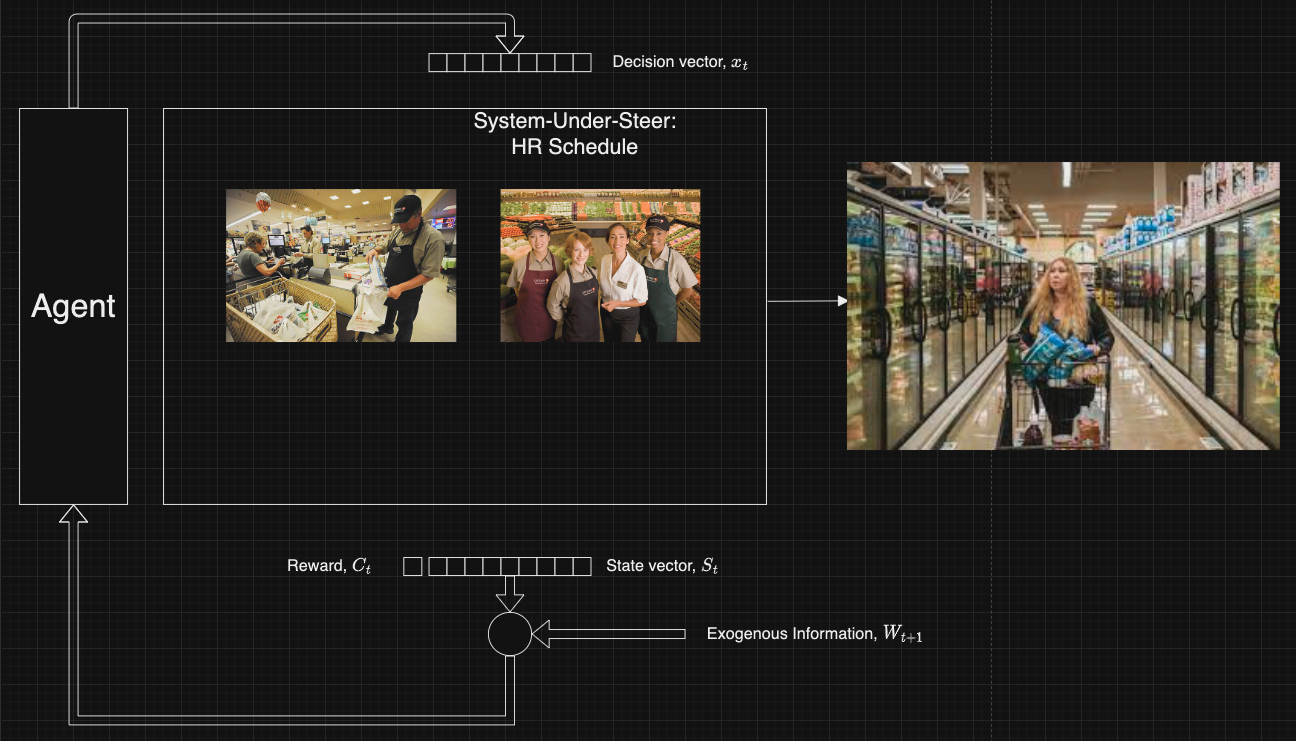

In [32]:
# myimage

testing ...
![AIShiftScheduler1](myimage)

testing2 ...
![AIShiftScheduler1](cf.PATH_AIShiftScheduler1)

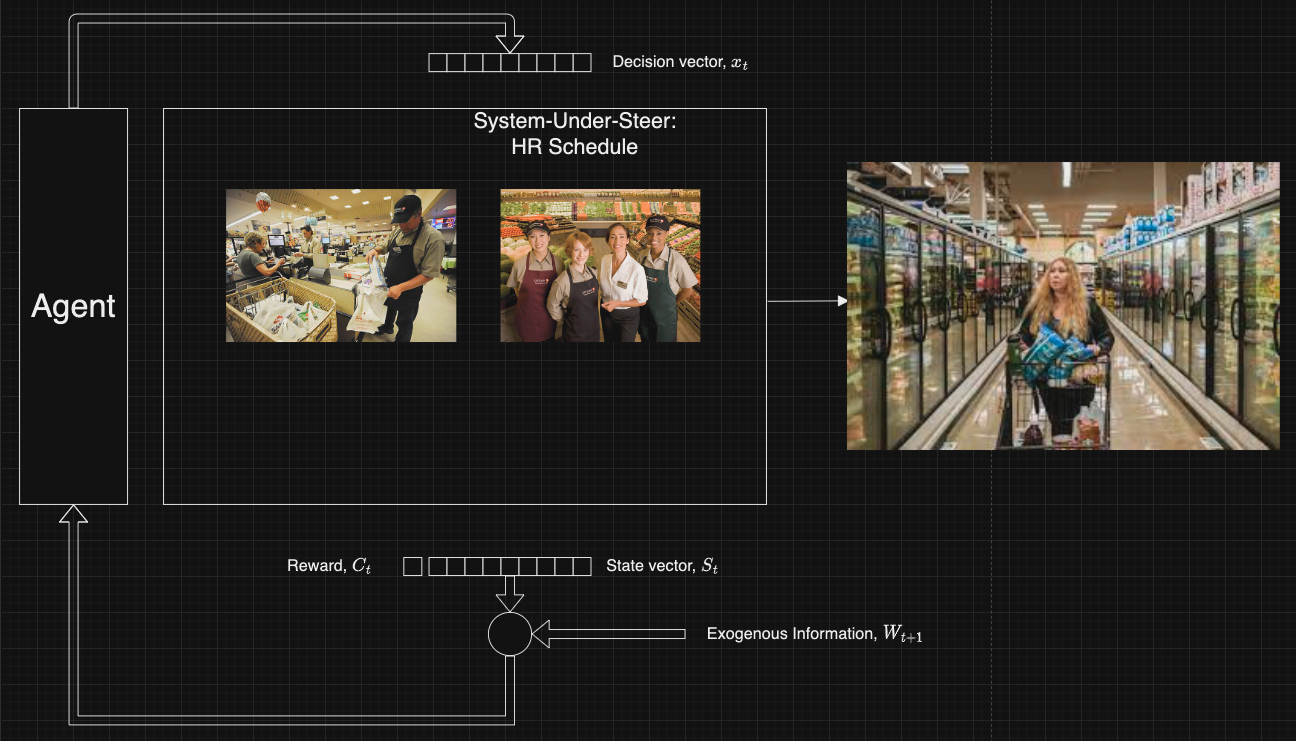

In [33]:
# Image.open(cf.PATH_AIShiftScheduler1)

In [34]:
# \\\\\\\\\\\\\\\\\\\\\\

Please review the narrative in section 1. The next figure is a representation of the solution to the problem:

![AIShiftScheduler1](AIShiftScheduler1.png)

### 4.2 Core Elements

This section attempts to answer three important questions:

- What metrics are we going to track?
- What decisions do we intend to make?
- What are the sources of uncertainty?

For this problem, the only metric we are interested in is the cumulative reward after each horizon. The only source of uncertainty is the levels of demand and the merits/demerits for each of the resource types.

### 4.3 Mathematical Model | SUS Design
Please see the `model` module.

### 4.4 Uncertainty Model

We will simulate the shift demand vector $D^{Shift}_{t+1}$, and number of merits vector $n^{Merits}_{t+1}$ as described in section 2.

### 4.5 Policy Design
Please see the `policy` module.

### 4.6 Policy Evaluation
Please see the `policy` module.???

#### 4.6.0 Visualization
Please see the `visualization` module.

#### 4.6.1 Training/Tuning
Please see `trainer` module

In [35]:
V = vis.Visualization()

In [36]:
# # hide
# # QUICK STEP
# def print_S_t():
#   print(f'M.S_t["R_t"]=\n{M.S_t["R_t"]}')
#   print(f'M.S_t["D_t"]=\n{M.S_t["D_t"]}')

# def print_x_t():
#   # print(f'x_t.x_t= {x_t.x_t}')
#   print(f'M.x_t["xAlloc_t"]=\n{M.x_t["xAlloc_t"]}')

# record = []
# l = 1
# M = mod.Model()
# P = pol.Policy(M)
# ## DEM = DemandSimulator(seed=SEED_TRAIN); print(f'{DEM.simulate()=}')
# ## MER = MeritSimulator(seed=SEED_TRAIN); print(f'{MER.simulate()=}')

# theta_test = P.build_theta({
#   'thCumSlots': .1,
#   'thSickProb': .3,
#   'thCumMerits': .2,
#   'thContSlots': 1 - (.6),
#   'thSelect': 'random'
# })
# record_l = [cf.piNAMES[0], theta_test, l]; print(f'{record_l=}')
# print_S_t()
# print_x_t()

In [37]:
# ## hide
# # T = 7*24
# # T = 2*24
# T = 2
# # T = 1*SLOTS_PER_DAY
# # T = 2*SLOTS_PER_DAY
# dt = pd.to_datetime(cf.START_DATE_TIME)
# dt_delta = pd.Timedelta(cf.DATE_TIME_DELTA)
# for t in range(T):
#   print(f'\n################# t={t}, dt={dt} #################')
#   # getattr(P, 'X__AllocBelow')(t, M.S_t, M.x_t, theta_test); #print(f'{x_t=}')
#   getattr(P, 'X__Alloc')(t, dt, M.S_t, M.x_t, theta_test); #print(f'{x_t=}')
#   print_S_t()
#   print_x_t()

#   # record_t = M.step(t, theta_test)
#   record_t = M.step(t, dt, theta_test)
#   print(f'\nAFTER STEP:')
#   record.append(record_l + record_t); #print(f'{record=}')
#   dt = dt + dt_delta
#   # print_S_t()
#   # print(f'{M.Ccum=}')

In [38]:
# ## hide
# df_test_n_t = pd.DataFrame.from_records(record, columns=cf.LABELS)
# df_test_n_t.tail()

In [39]:
# ## hide
# V.plot_records(
#   df=df_test_n_t,
#   df_non=None,
#   pars=defaultdict(str, {
#     # 'thetaAdj1': {a1n: theta_test.thAdj1[a1n] for a1n in a1NAMES},
#     # 'thetaAdj3': {a1n: theta_test.thAdj3[a1n] for a1n in a1NAMES},
#     # 'suptitle': f'TRAINING OF X__AdjBelow POLICY'+'\n'+f'(first {first_n_t} records)'+'\n'+ \
#     # f'L = {L}, T = {T}, '+ \
#     # r'$\theta^*=$'+f'{P.round_theta(best_theta_AdjBelow)}',
#     'T': T
#   }),
# )

In [43]:
# don't export, else will run each time this module is loaded; just for dev
ThetasCumSlots = np.arange(cf.TH_CumSlots_SPEC[0], cf.TH_CumSlots_SPEC[1], cf.TH_CumSlots_SPEC[2])
## ThetasCumSlots = TH_CumSlots_SPEC

## ThetasSickProb = np.arange(TH_SickProb_SPEC[0], TH_SickProb_SPEC[1], TH_SickProb_SPEC[2])
ThetasSickProb = cf.TH_SickProb_SPEC

ThetasCumMerits = np.arange(cf.TH_CumMerits_SPEC[0], cf.TH_CumMerits_SPEC[1], cf.TH_CumMerits_SPEC[2])
## ThetasCumMerits = TH_CumMerits_SPEC

## BALANCE/REMAINING 
## ThetasContSlots = np.arange(TH_ContSlots_SPEC[0], TH_ContSlots_SPEC[1], TH_ContSlots_SPEC[2])
## ThetasContSlots = TH_ContSlots_SPEC

ThetasSelect = cf.TH_Select_SPEC

thetas_list = [
    ( round(th0,2), round(th1,2), round(th2,2), round(1-(th0+th1+th2),2), th4 )
    for th0 in ThetasCumSlots
      for th1 in ThetasSickProb
        for th2 in ThetasCumMerits if (th0 + th1 + th2) <= 1.0
          for th4 in ThetasSelect
]
Thetas = [
    ## P.build_theta({'thCumSlots': tup[0], 'thSickProb': tup[1], 'thCumMerits': tup[2], 'thSelect': tup[3]})
    pol.Policy(None).build_theta({
      'thCumSlots': tup[0], 
      'thSickProb': tup[1], 
      'thCumMerits': tup[2], 
      'thContSlots': tup[3], 
      'thSelect': tup[4]
      })
    for tup in thetas_list
]

In [44]:
# don't export, else will run each time this module is loaded; just for dev
start = time.time()
ray.shutdown()
ray.init()

L = 2 #5 #20 #10 #5 #2 #3 #2db #10pub
T = 7*Pars.SLOTS_PER_DAY #5 #7*96
First_n_t = int(1.2*T)
Last_n_t = int(1*T) ##make whole multiple of T to look better in chart

ThetaStar_expCbarcum, ThetaStar_expCtilcum, \
Cbarcum, Ctilcum, \
Best_theta, Worst_theta, \
Best_Cbarcum, Worst_Cbarcum, \
Best_Ctilcum, Worst_Ctilcum, \
Record = \
  trn.do_train(L, T, Thetas, Pars)

f'{ThetaStar_expCbarcum.iloc[-1]=:.2f}'
Df_first_n_t = pd.DataFrame.from_records(Record[:First_n_t], columns=Pars.LABELS)
Df_last_n_t = pd.DataFrame.from_records(Record[-Last_n_t:], columns=Pars.LABELS)
end = time.time(); print(f'EXECUTION TIME: {end - start} seconds')

2024-03-01 03:40:12,592	INFO worker.py:1724 -- Started a local Ray instance.


numThetas=8
... printing every 1th theta (if considered) ...
(pid=42560) /Users/kobus/aishiftscheduler/aishiftscheduler/shift_scheduler_data.xlsx
(pid=42560) /Users/kobus/aishiftscheduler/aishiftscheduler/AIShiftScheduler1.png
(pid=42555) thNAMES=['thCumSlots', 'thSickProb', 'thCumMerits', 'thContSlots', 'thSelect']
(parallel_run_grid_sample_paths pid=42560) 	%%% l=1
(pid=42558) /Users/kobus/aishiftscheduler/aishiftscheduler/shift_scheduler_data.xlsx [repeated 7x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(pid=42558) len(thNAMES)=5 [repeated 23x across cluster]
(pid=42558) thNAMES=['thCumSlots', 'thSickProb', 'thCumMerits', 'thContSlots', 'thSelect'] [repeated 7x across cluster]
(parallel_run_grid_sample_paths pid=42559) 	%%% l=2 [repeated 8x across cluster]
0/7, 443,752, Theta(thCumSlots=0.0, thSickProb=0, thCumMerits=0

In [45]:
if 'TRAIN' in cf.MODES: print(Best_theta)

Theta(thCumSlots=0.5, thSickProb=0, thCumMerits=0.5, thContSlots=0.0, thSelect='random')


In [46]:
#/// ## TRAIN ENTRY-POINT
# ## @anvil.server.callable
# # def get_schedule(start, slots_per_day, max_daily_slot_run, resources, demands_per_busyness, resource_expenses):
# # def get_schedule(
# def train_schedule(
#     start, 
#     slots_per_day, 
#     max_daily_slot_run, 
#     resources, 
#     demands_per_busyness, 
#     demands_per_volume, 
#     demands_per_revenue, 
#     resource_expenses):
#     pass

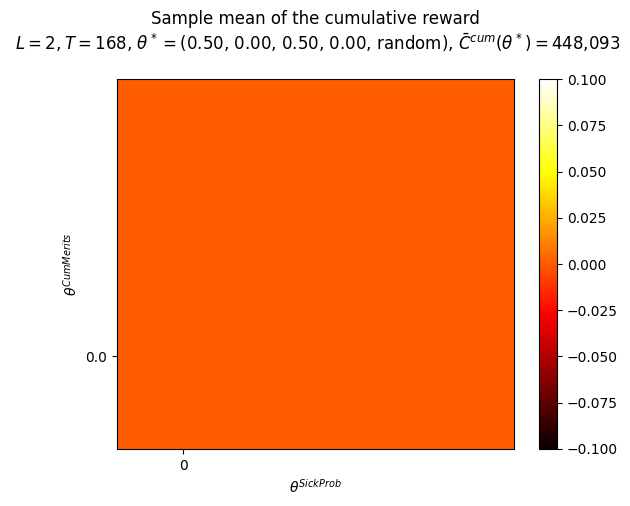

True

In [47]:
## P.plot_Fhat_map_5(
V.plot_Fhat_map_4(
  FhatI_theta_I=Cbarcum,

  ## thetasX=thetasCumSlots,
  thetasX=ThetasSickProb,
  thetasY=ThetasCumMerits,

  ## labelX=r'$\theta^{CumSlots}$',
  labelX=r'$\theta^{SickProb}$',
  labelY=r'$\theta^{CumMerits}$',

  title="Sample mean of the cumulative reward"+f"\n $L={L}, T={T}$, "+ \
    r"$\theta^* =$("+ \
      str(f'{Best_theta[0]:,.2f}')+", "+ \
      str(f'{Best_theta[1]:,.2f}')+", "+ \
      str(f'{Best_theta[2]:,.2f}')+", "+ \
      str(f'{Best_theta[3]:,.2f}')+", "+ \
      f'{Best_theta[4]}'+"), " \
    r"$\bar{C}^{cum}(\theta^*) =$"+f"{Best_Cbarcum:,.0f}\n",
  ## thetaFixed1=best_theta.thCumMerits,
  ## thetaFixed1=best_theta.thSickProb,
  ## thetaFixed1=best_theta.thCumSlots,
  thetaFixed1=Best_theta.thContSlots,
  thetaFixed2=Best_theta.thSelect,
)

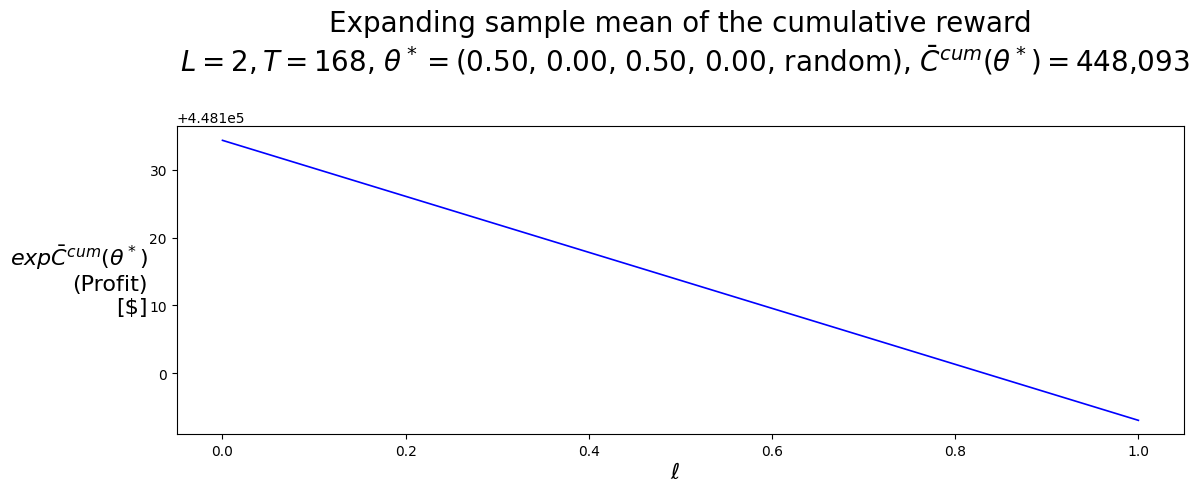

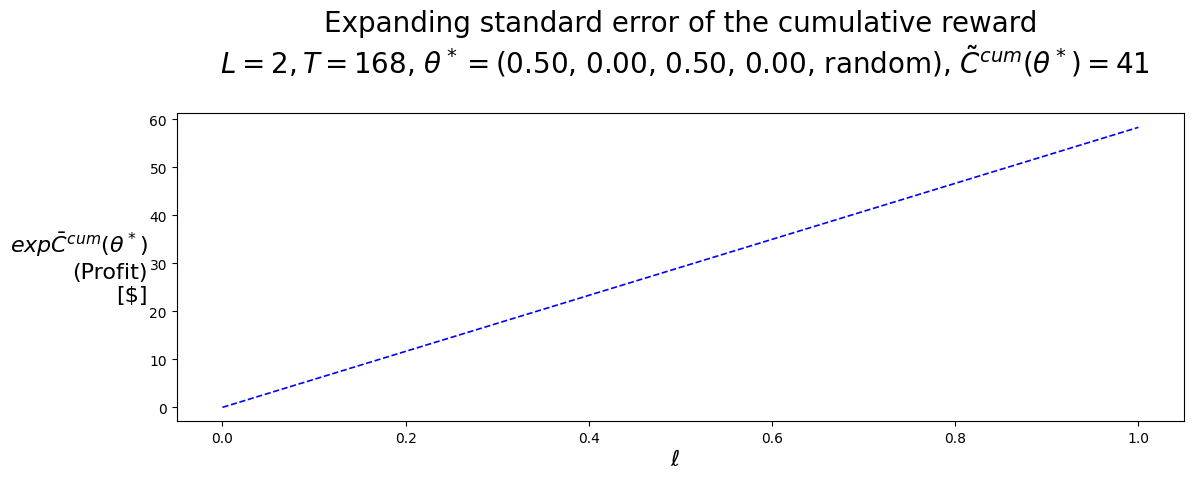

In [48]:
V.plot_expFhat_chart(
  df=ThetaStar_expCbarcum,
  labelX=r'$\ell$',
  labelY=r"$exp\bar{C}^{cum}(\theta^*)$"+"\n(Profit)\n[$]",
  title="Expanding sample mean of the cumulative reward"+f"\n $L={L}, T={T}$, "+ \
    r"$\theta^* =$("+ \
      str(f'{Best_theta[0]:,.2f}')+", "+ \
      str(f'{Best_theta[1]:,.2f}')+", "+ \
      str(f'{Best_theta[2]:,.2f}')+", "+ \
      str(f'{Best_theta[3]:,.2f}')+", "+
      f'{Best_theta[4]}'+"), " \
    r"$\bar{C}^{cum}(\theta^*) =$"+f"{Best_Cbarcum:,.0f}\n",
  color_style='b-'
)
print()
V.plot_expFhat_chart(    
  df=ThetaStar_expCtilcum,
  labelX=r'$\ell$',
  labelY=r"$exp\bar{C}^{cum}(\theta^*)$"+"\n(Profit)\n[$]",
  title="Expanding standard error of the cumulative reward"+f"\n $L={L}, T={T}$, "+ \
    r"$\theta^* =$("+ \
      str(f'{Best_theta[0]:,.2f}')+", "+ \
      str(f'{Best_theta[1]:,.2f}')+", "+ \
      str(f'{Best_theta[2]:,.2f}')+", "+ \
      str(f'{Best_theta[3]:,.2f}')+", "+
      f'{Best_theta[4]}'+"), " \
    r"$\tilde{C}^{cum}(\theta^*) =$"+f"{Best_Ctilcum:,.0f}\n",
  color_style='b--'
)

In [49]:
if 'TRAIN' in cf.MODES: print(f'{len(Record):,}', L, T)

2,688 2 168


In [50]:
if 'TRAIN' in cf.MODES: print(Best_theta)

Theta(thCumSlots=0.5, thSickProb=0, thCumMerits=0.5, thContSlots=0.0, thSelect='random')


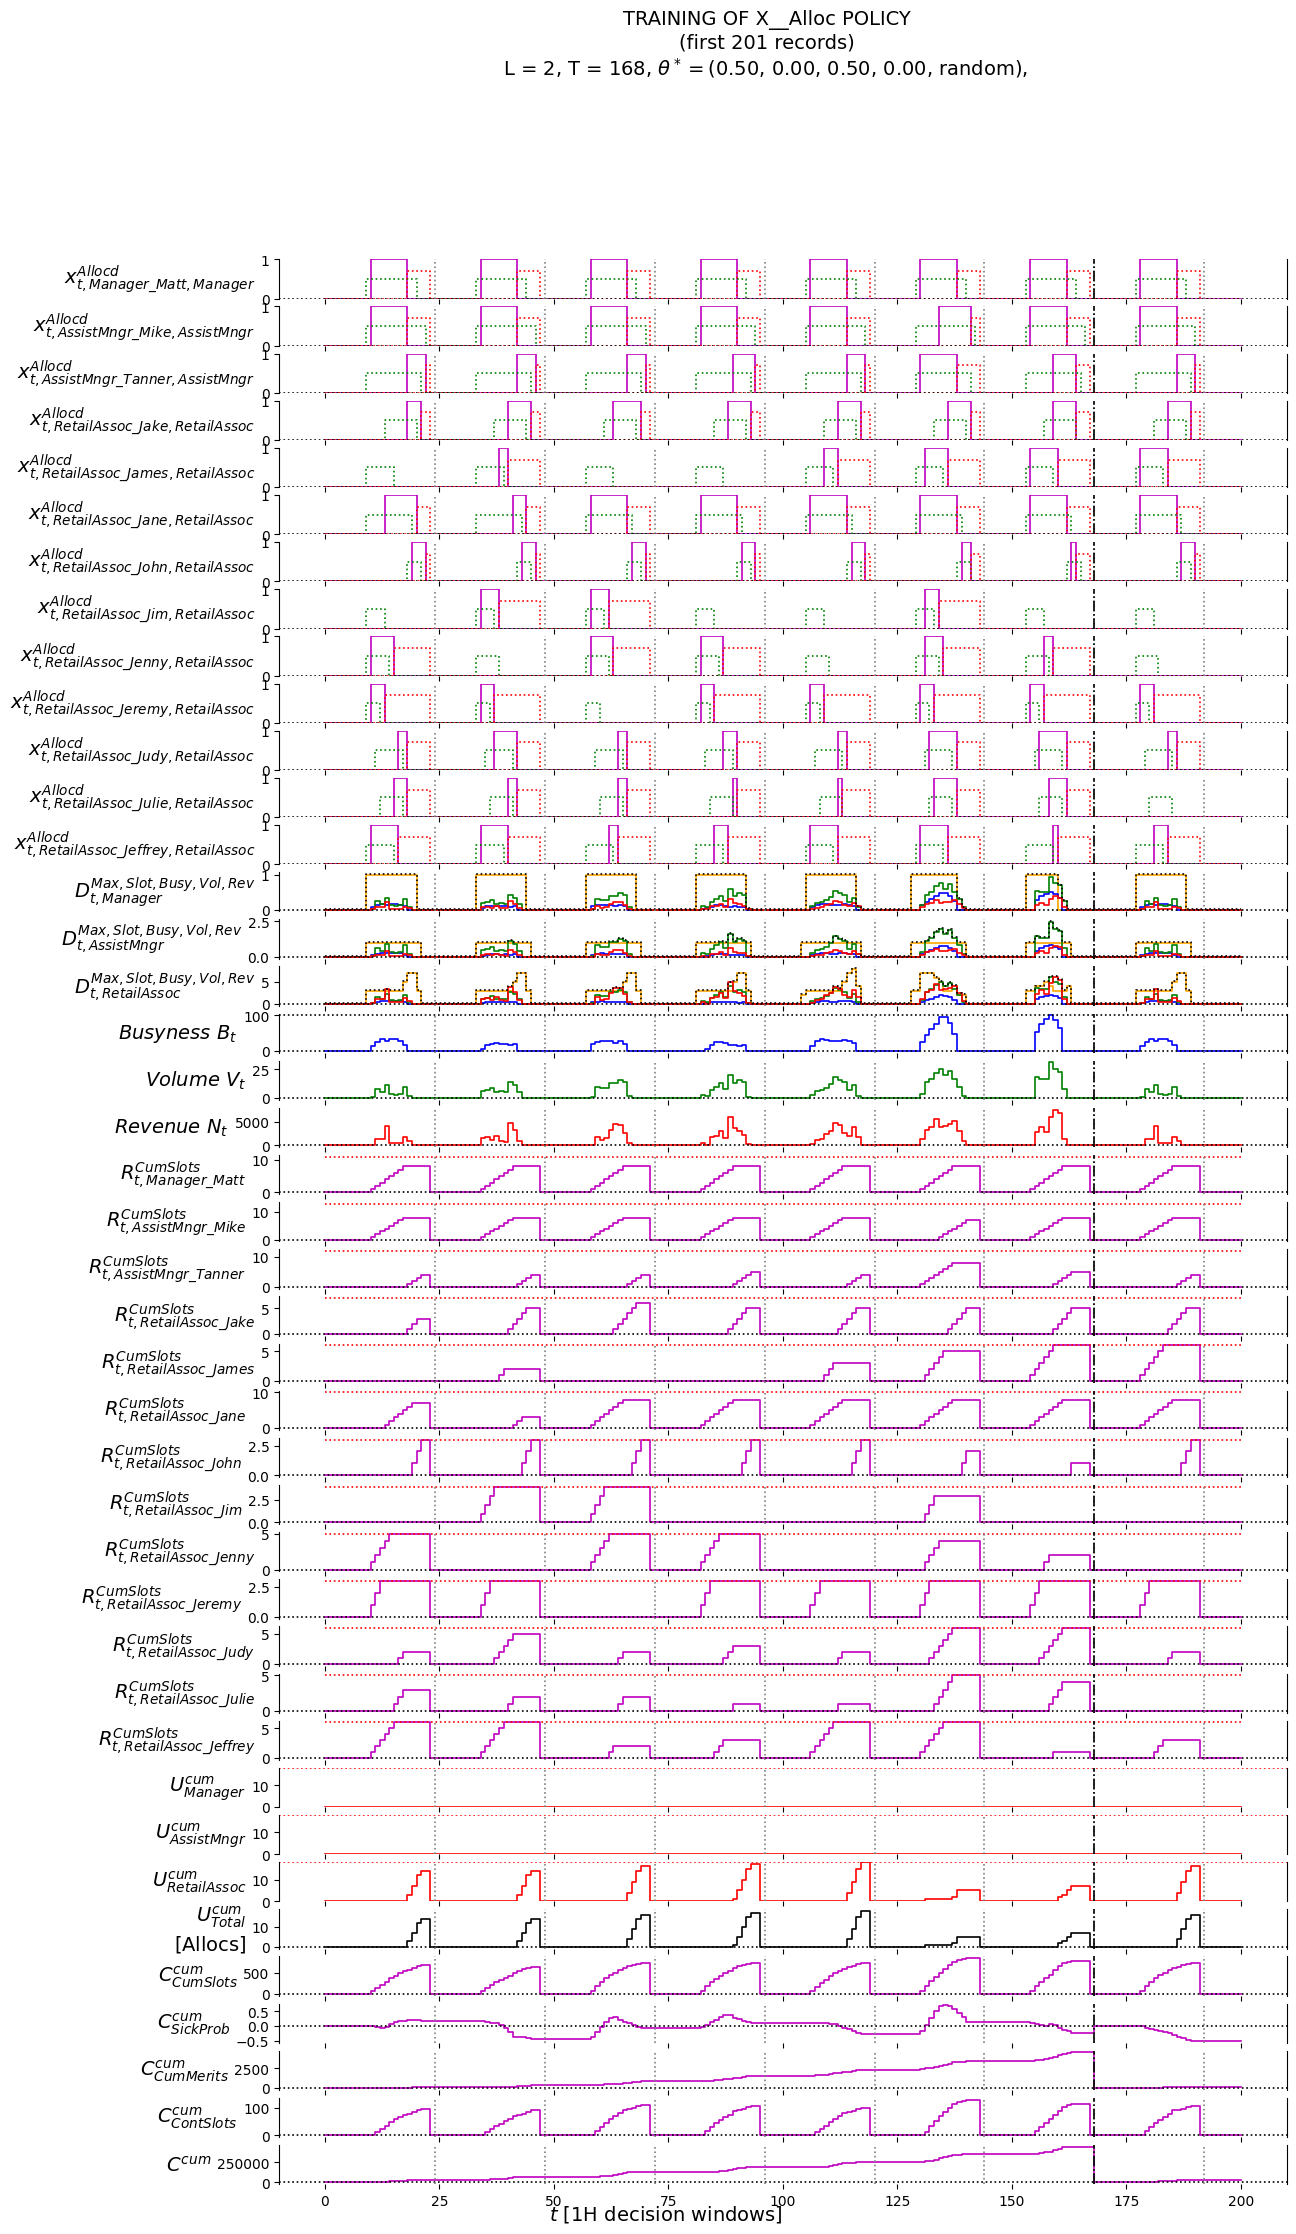

In [51]:
V.plot_records(
  Pars,
  df=Df_first_n_t,
  df_non=None,
  pars=defaultdict(str, {
    'T': T,
    'xlabel': "$t\ \mathrm{["+f"{Pars.DATE_TIME_DELTA}"+"\ decision\ windows]}$",
    'thCumSlots': Best_theta.thCumSlots,
    'thSickProb': Best_theta.thSickProb,
    ## 'legendLabels': [r'$\mathrm{opt}$', r'$\mathrm{non}$'],
    'suptitle': f'TRAINING OF X__Alloc POLICY'+'\n'+f'(first {First_n_t} records)'+'\n'+ \
    f'L = {L}, T = {T}, '+ \
    r"$\theta^* =$("+ \
      str(f'{Best_theta[0]:,.2f}')+", "+ \
      str(f'{Best_theta[1]:,.2f}')+", "+ \
      str(f'{Best_theta[2]:,.2f}')+", "+ \
      str(f'{Best_theta[3]:,.2f}')+", "+
      f'{Best_theta[4]}'+"), " \
  }),
);

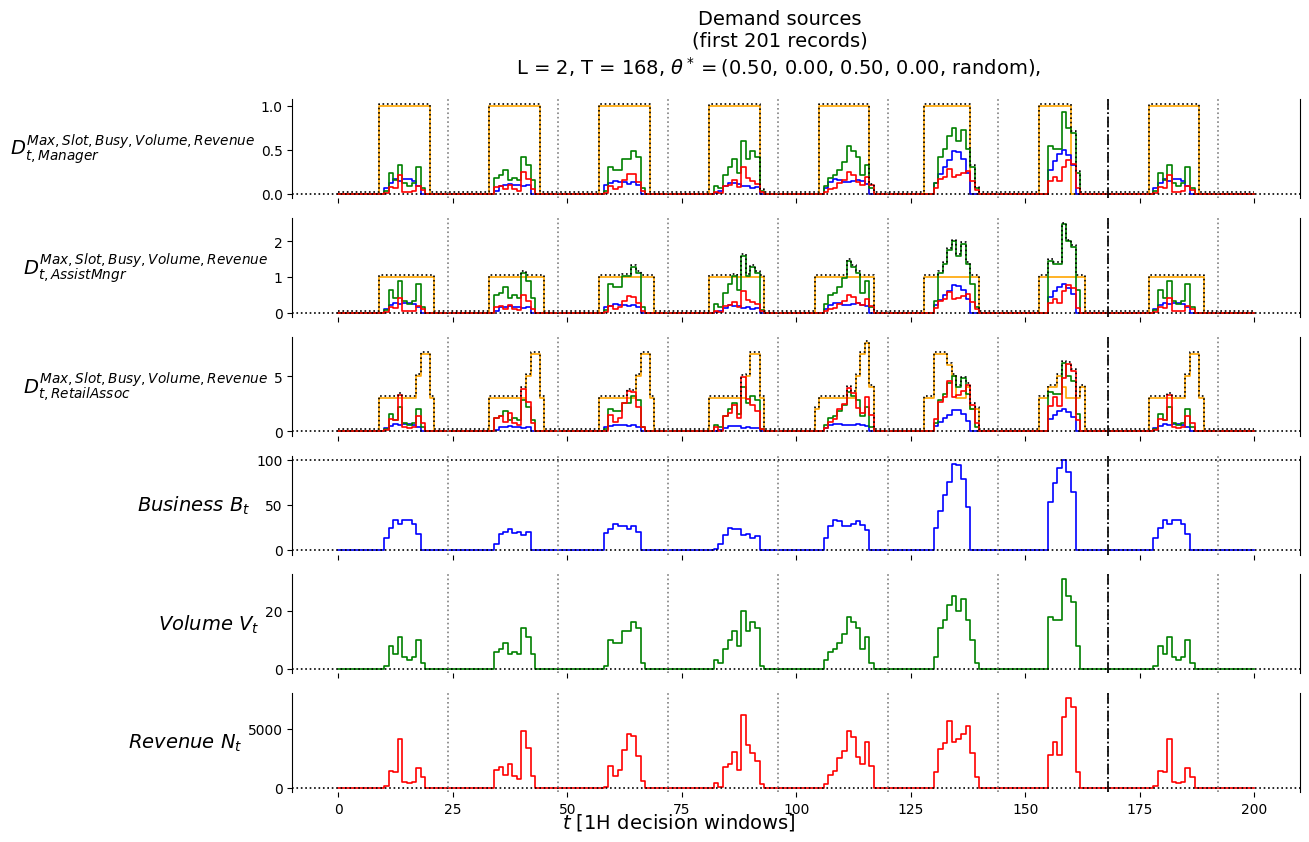

In [52]:
V.plot_demand_sources(
  Pars,
  df=Df_first_n_t,
  pars=defaultdict(str, {
    'T': T, 
    'xlabel': "$t\ \mathrm{["+f"{Pars.DATE_TIME_DELTA}"+"\ decision\ windows]}$",
    'suptitle': f'Demand sources'+'\n'+f'(first {First_n_t} records)'+'\n'+ \
    f'L = {L}, T = {T}, '+ \
    r"$\theta^* =$("+ \
      str(f'{Best_theta[0]:,.2f}')+", "+ \
      str(f'{Best_theta[1]:,.2f}')+", "+ \
      str(f'{Best_theta[2]:,.2f}')+", "+ \
      str(f'{Best_theta[3]:,.2f}')+", "+
      f'{Best_theta[4]}'+"), " \
  }),
);

In [53]:
if 'TRAIN' in cf.MODES: print(T, Pars.SLOTS_PER_DAY)

168 24


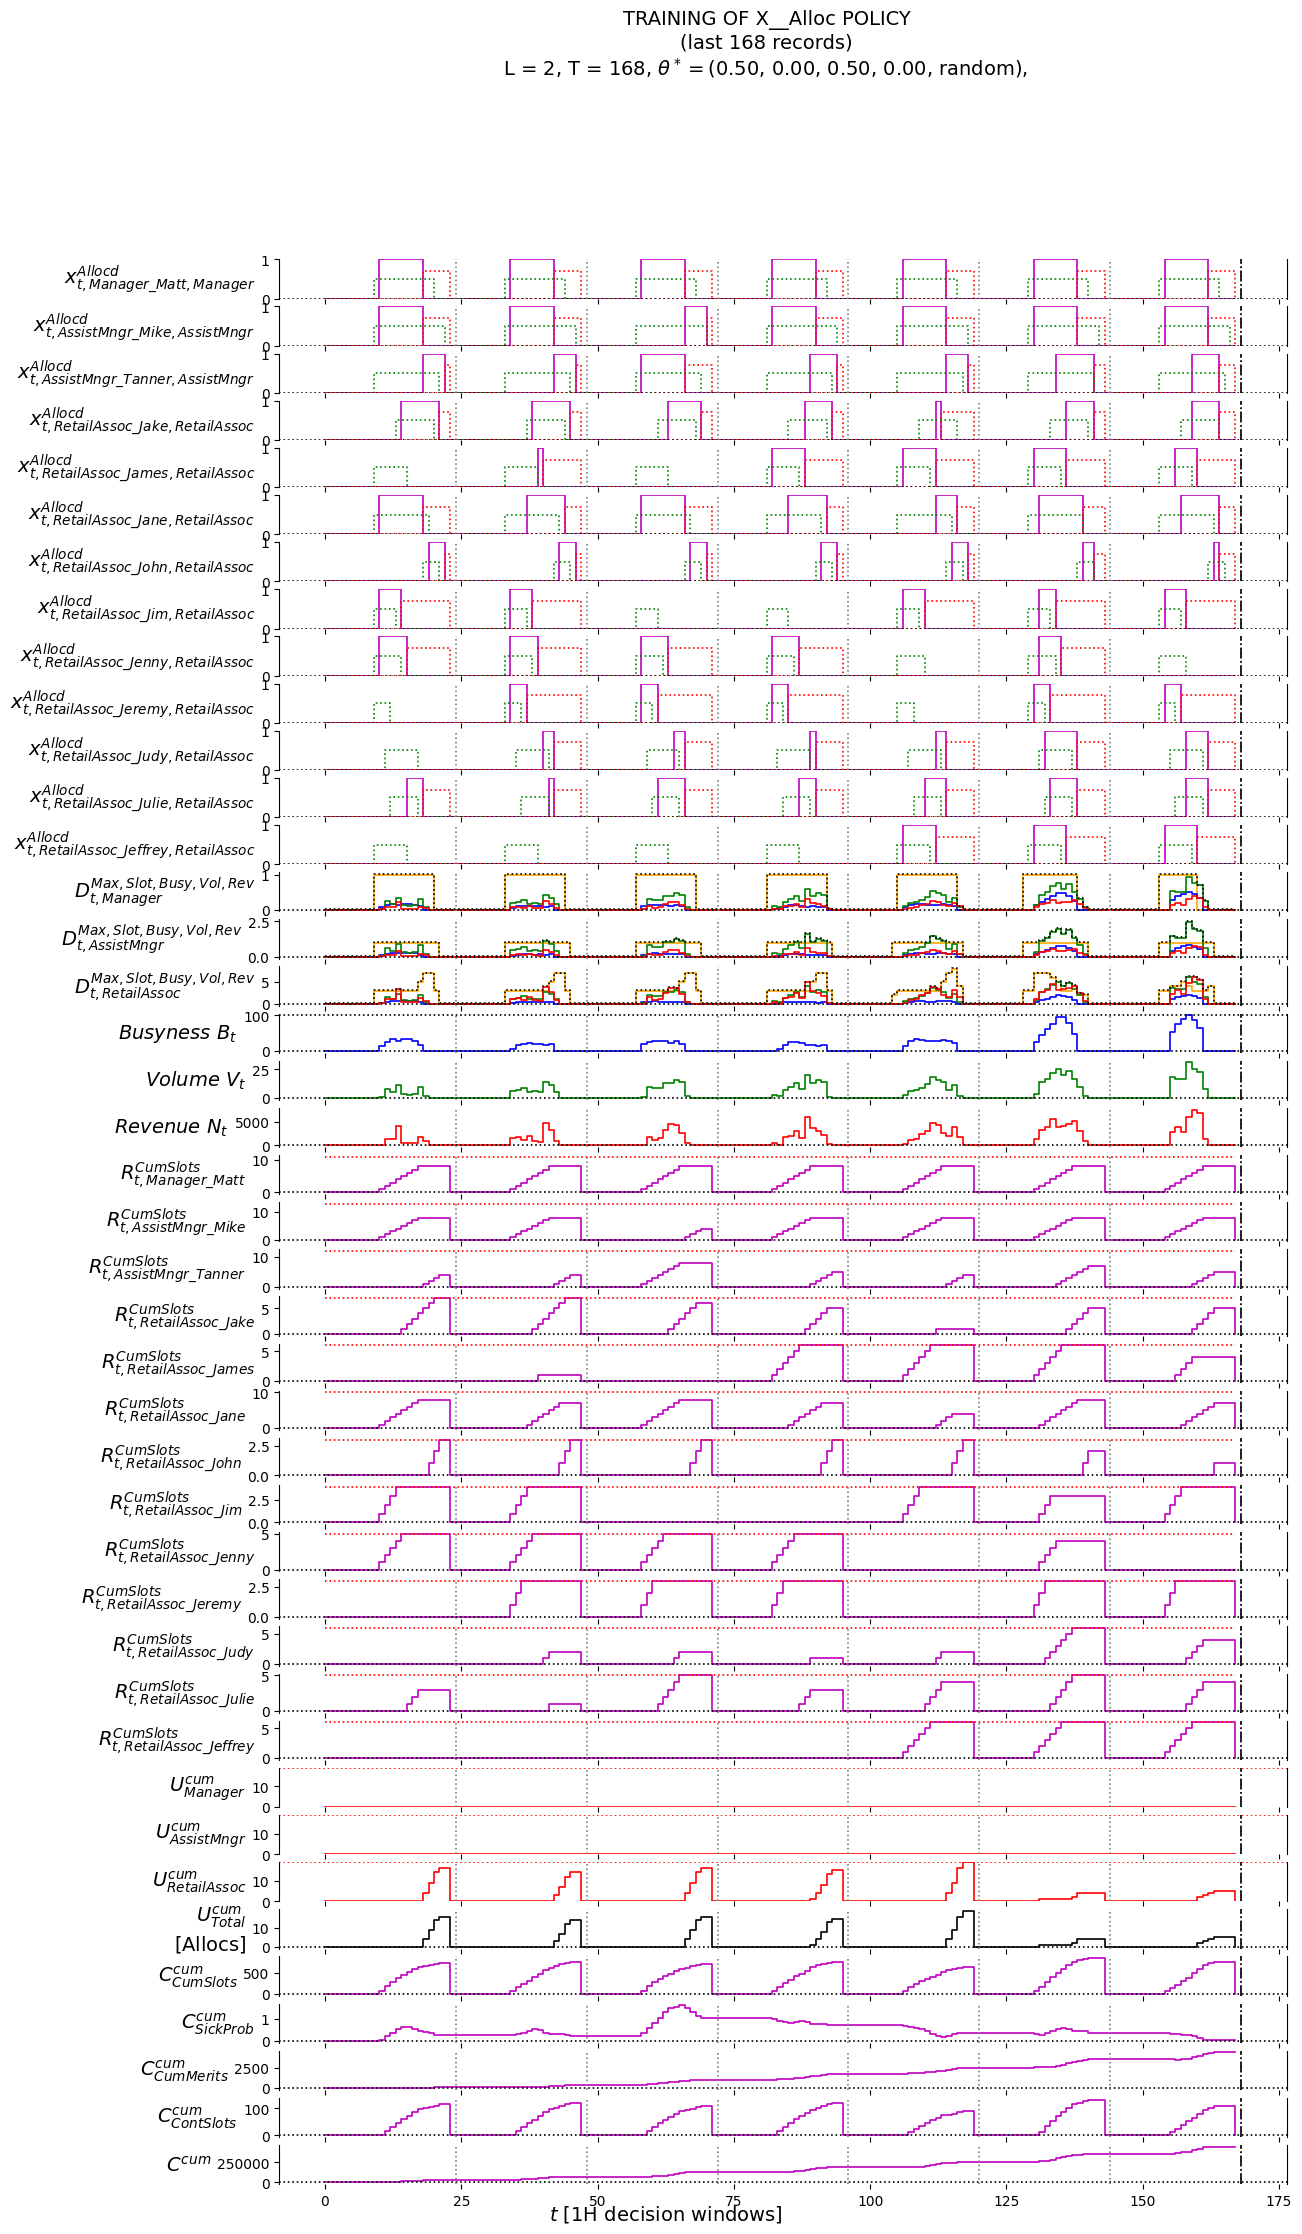

In [54]:
V.plot_records(
  Pars,
  df=Df_last_n_t,
  df_non=None,
  pars=defaultdict(str, {
    'T': T, 
    'thCumSlots': Best_theta.thCumSlots,
    'thSickProb': Best_theta.thSickProb,
    ## 'legendLabels': [r'$\mathrm{opt}$', r'$\mathrm{non}$'],
    'xlabel': "$t\ \mathrm{["+f"{Pars.DATE_TIME_DELTA}"+"\ decision\ windows]}$",
    'suptitle': f'TRAINING OF X__Alloc POLICY'+'\n'+f'(last {Last_n_t} records)'+'\n'+ \
    f'L = {L}, T = {T}, '+ \
    r"$\theta^* =$("+ \
      str(f'{Best_theta[0]:,.2f}')+", "+ \
      str(f'{Best_theta[1]:,.2f}')+", "+ \
      str(f'{Best_theta[2]:,.2f}')+", "+ \
      str(f'{Best_theta[3]:,.2f}')+", "+
      f'{Best_theta[4]}'+"), " \
  }),
)

#### 4.6.1.2 Comparison of Policies

In [55]:
## hide
## last_n_l = int(.95*L)
## P.plot_expFhat_charts(
#   means={
#       'HighLow': thetaStar_expCbarcum_HighLow[-last_n_l:],
#       'SellLow': thetaStar_expCbarcum_SellLow[-last_n_l:],
#       'Track': thetaStar_expCbarcum_Track[-last_n_l:]
#   },
#   stdvs={
#       'HighLow': thetaStar_expCtilcum_HighLow[-last_n_l:],
#       'SellLow': thetaStar_expCtilcum_SellLow[-last_n_l:],
#       'Track': thetaStar_expCtilcum_Track[-last_n_l:]
#   },
#   labelX='Sample paths, ' + r'$\ell$',
#   labelY='Profit\n[$]',
#   suptitle=f"Comparison of Policies after Training\n \
#     L = {L}, T = {T}\n \
#     last {last_n_l} records\n \
#     ('exp' refers to expanding)",
#   pars=defaultdict(str, {
#     'colors': ['r', 'g', 'b']
#   }),
# )

#### 4.6.2 Evaluation
Please see `evaluator` module.

##### 4.6.2.1 X__AllocBelow

In [56]:
if 'EVALU' in cf.MODES: print(Best_theta)

Theta(thCumSlots=0.5, thSickProb=0, thCumMerits=0.5, thContSlots=0.0, thSelect='random')


In [57]:
if 'EVALU' in cf.MODES: print(Worst_theta)

Theta(thCumSlots=0.0, thSickProb=0.5, thCumMerits=0.0, thContSlots=0.5, thSelect='random')


In [58]:
# don't export, else will run each time this module is loaded; just for dev
start = time.time()
## to test
# if 'EVALU' in cf.MODES:
L = 2 #20 #5 #2 #2db #10pub
T = 7*Pars.SLOTS_PER_DAY #=672
First_n_t = int(.11*L*T)

ThetaStar_expCbarcum_evalu_opt, ThetaStar_expCtilcum_evalu_opt, \
_, _, \
Best_theta_evalu_opt, Worst_theta_evalu_opt, \
_, _, \
_, _, \
Record_evalu_opt = \
  evl.do_evalu_opt(L, T, Best_theta, Pars)

Df_evalu_opt = pd.DataFrame.from_records(
  Record_evalu_opt[:First_n_t], columns=Pars.LABELS)
print(f'{ThetaStar_expCbarcum_evalu_opt.iloc[-1]=:.2f}')
end = time.time(); print(f'EXECUTION TIME: {end - start} seconds')

numThetas=1
... printing every 1th theta (if considered) ...
	%%% l=1
	%%% l=2
0/0, 448,059, Theta(thCumSlots=0.5, thSickProb=0, thCumMerits=0.5, thContSlots=0.0, thSelect='random')
ThetaStar_expCbarcum_evalu_opt.iloc[-1]=448058.58
EXECUTION TIME: 18.805290937423706 seconds


In [59]:
# don't export, else will run each time this module is loaded; just for dev
start = time.time()
## to test
# if 'EVALU' in cf.MODES:
L = 2 #20 #5 #2 #2db #10pub
T = 7*Pars.SLOTS_PER_DAY #=672
First_n_t = int(.11*L*T)

ThetaStar_expCbarcum_evalu_non, ThetaStar_expCtilcum_evalu_non, \
_, _, \
Best_theta_evalu_non, Worst_theta_evalu_non, \
_, _, \
_, _, \
Record_evalu_non = \
  evl.do_evalu_non(L, T, Worst_theta, Pars)

Df_evalu_non = pd.DataFrame.from_records(
  Record_evalu_non[:First_n_t], columns=Pars.LABELS)
print(f'{ThetaStar_expCbarcum_evalu_non.iloc[-1]=:.2f}')
end = time.time(); print(f'EXECUTION TIME: {end - start} seconds')

numThetas=1
... printing every 1th theta (if considered) ...
	%%% l=1
	%%% l=2
0/0, 443,372, Theta(thCumSlots=0.0, thSickProb=0.5, thCumMerits=0.0, thContSlots=0.5, thSelect='random')
ThetaStar_expCbarcum_evalu_non.iloc[-1]=443371.71
EXECUTION TIME: 18.958858013153076 seconds


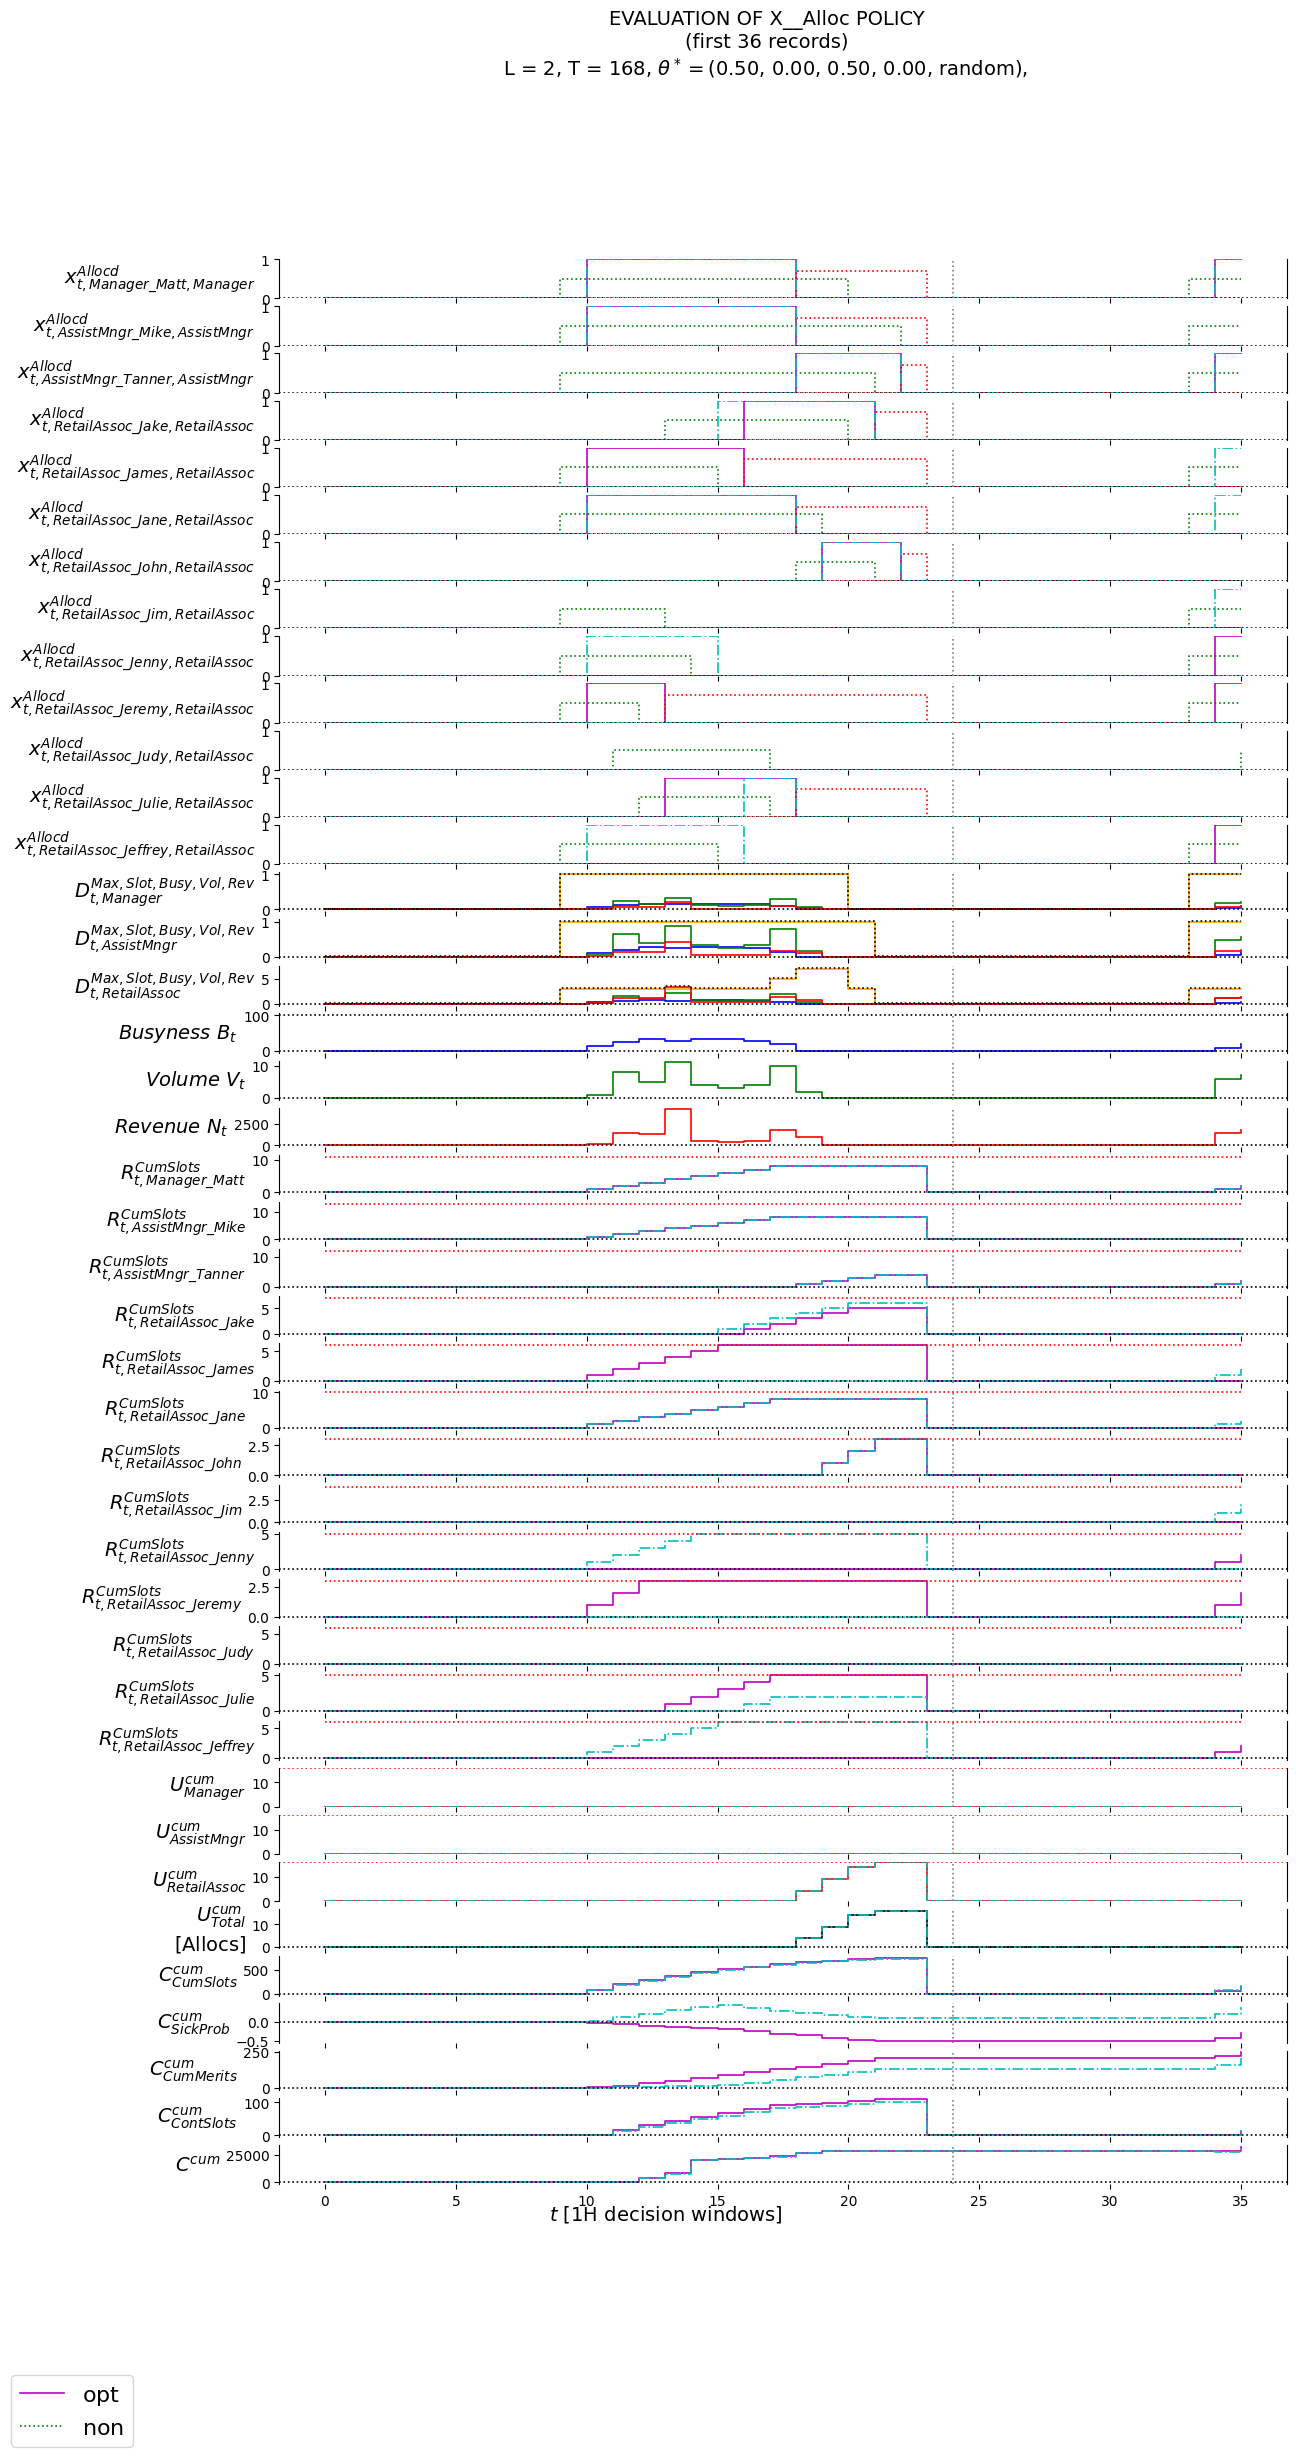

In [60]:
V.plot_records(
  Pars,
  df=Df_evalu_opt,
  df_non=Df_evalu_non,
  pars=defaultdict(str, {
    'T': T,
    'thCumSlots': Best_theta_evalu_opt.thCumSlots,
    'thSickProb': Best_theta_evalu_opt.thSickProb,
    'thCumSlotsNon': Best_theta_evalu_non.thCumSlots,
    'thSickProbNon': Best_theta_evalu_non.thSickProb,
    'legendLabels': [r'$\mathrm{opt}$', r'$\mathrm{non}$'],
    'xlabel': "$t\ \mathrm{["+f"{Pars.DATE_TIME_DELTA}"+"\ decision\ windows]}$",
    'suptitle': f'EVALUATION OF X__Alloc POLICY'+'\n'+f'(first {First_n_t} records)'+'\n'+ \
    f'L = {L}, T = {T}, '+ \
    r"$\theta^* =$("+ \
      str(f'{Best_theta_evalu_opt[0]:,.2f}')+", "+ \
      str(f'{Best_theta_evalu_opt[1]:,.2f}')+", "+ \
      str(f'{Best_theta_evalu_opt[2]:,.2f}')+", "+ \
      str(f'{Best_theta_evalu_opt[3]:,.2f}')+", "+
      f'{Best_theta_evalu_opt[4]}'+"), " \
  }),
)

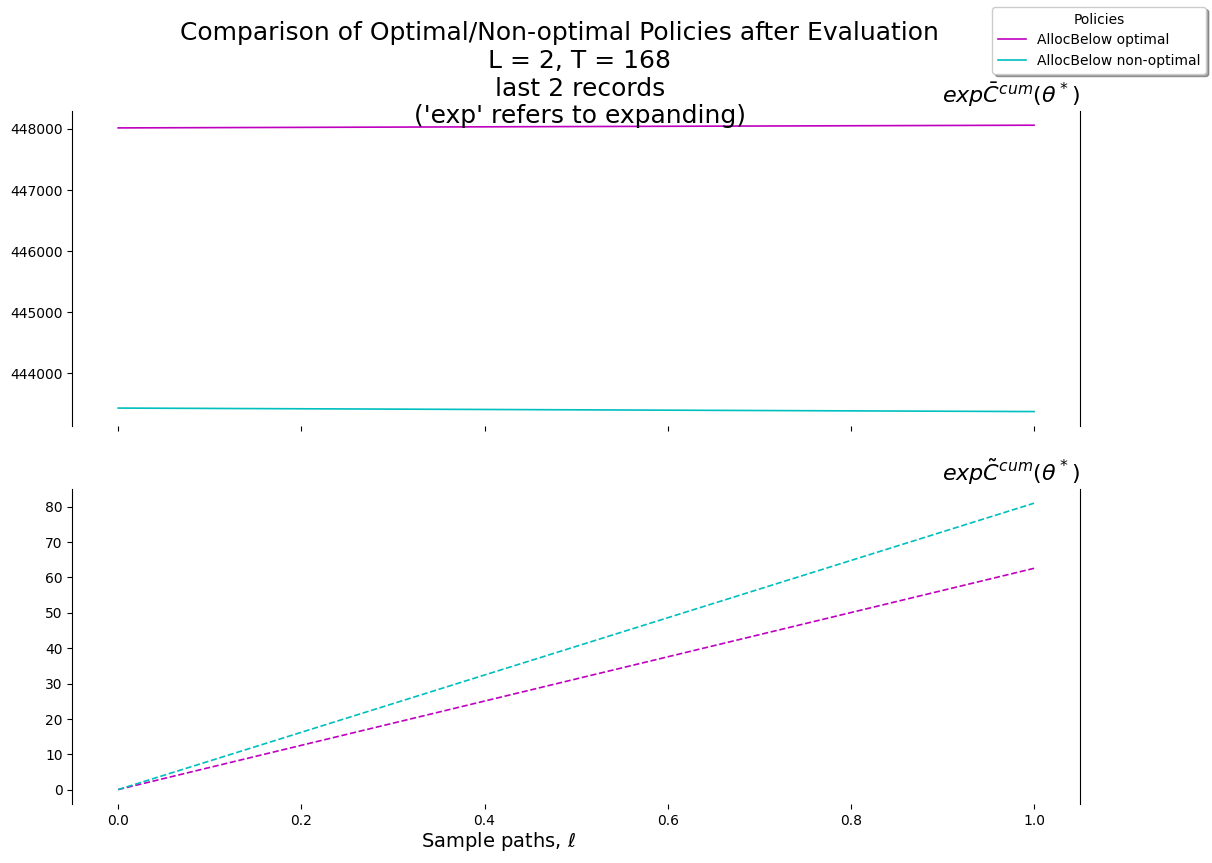

In [61]:
## last_n_l = int(.99*L)
Last_n_l = int(1.0*L)
V.plot_expFhat_charts(
  means={
    'AllocBelow optimal': ThetaStar_expCbarcum_evalu_opt[-Last_n_l:],
    'AllocBelow non-optimal': ThetaStar_expCbarcum_evalu_non[-Last_n_l:],
  },
  stdvs={
    'AllocBelow optimal': ThetaStar_expCtilcum_evalu_opt[-Last_n_l:],
    'AllocBelow non-optimal': ThetaStar_expCtilcum_evalu_non[-Last_n_l:],
  },
  labelX='Sample paths, ' + r'$\ell$',
  ## labelY='Profit\n[Allocs]',
  labelY='',
  suptitle=f"Comparison of Optimal/Non-optimal Policies after Evaluation\n \
    L = {L}, T = {T}\n \
    last {Last_n_l} records\n \
    ('exp' refers to expanding)",
  pars=defaultdict(str, {
    'colors': ['m', 'c']
  }),
)

Next, we evaluate with a single sample-path:

In [62]:
# don't export, else will run each time this module is loaded; just for dev
start = time.time()
L = 1 #20 #5 #2 #2db #10pub
T = 7*Pars.SLOTS_PER_DAY #=672
First_n_t = int(1*L*T)

ThetaStar_expCbarcum_evalu_opt, ThetaStar_expCtilcum_evalu_opt, \
_, _, \
Best_theta_evalu_opt, Worst_theta_evalu_opt, \
_, _, \
_, _, \
Record_evalu_opt = \
  evl.do_evalu_opt(L, T, Best_theta, Pars)

Df_evalu_opt = pd.DataFrame.from_records(
  Record_evalu_opt[:First_n_t], columns=Pars.LABELS)
print(f'{ThetaStar_expCbarcum_evalu_opt.iloc[-1]=:.2f}')
end = time.time(); print(f'EXECUTION TIME: {end - start} seconds')

numThetas=1
... printing every 1th theta (if considered) ...
	%%% l=1
0/0, 447,927, Theta(thCumSlots=0.5, thSickProb=0, thCumMerits=0.5, thContSlots=0.0, thSelect='random')
ThetaStar_expCbarcum_evalu_opt.iloc[-1]=447927.33
EXECUTION TIME: 9.418468952178955 seconds


/Users/kobus/aishiftscheduler/aishiftscheduler/policy.py:212: RuntimeWarning: invalid value encountered in scalar divide
  Ctilcum_tmp = np.sum(np.square(np.array(CcumIomega__lI) - Cbarcum_tmp))/(L - 1)


In [63]:
# don't export, else will run each time this module is loaded; just for dev
start = time.time()
L = 1 #20 #5 #2 #2db #10pub
T = 7*Pars.SLOTS_PER_DAY #=672
First_n_t = int(1*L*T)

ThetaStar_expCbarcum_evalu_non, ThetaStar_expCtilcum_evalu_non, \
_, _, \
Best_theta_evalu_non, Worst_theta_evalu_non, \
_, _, \
_, _, \
Record_evalu_non = \
  evl.do_evalu_non(L, T, Worst_theta, Pars)

Df_evalu_non = pd.DataFrame.from_records(
  Record_evalu_non[:First_n_t], columns=Pars.LABELS)
print(f'{ThetaStar_expCbarcum_evalu_non.iloc[-1]=:.2f}')
end = time.time(); print(f'EXECUTION TIME: {end - start} seconds')

numThetas=1
... printing every 1th theta (if considered) ...
	%%% l=1
0/0, 443,322, Theta(thCumSlots=0.0, thSickProb=0.5, thCumMerits=0.0, thContSlots=0.5, thSelect='random')
ThetaStar_expCbarcum_evalu_non.iloc[-1]=443322.26
EXECUTION TIME: 9.529253959655762 seconds


/Users/kobus/aishiftscheduler/aishiftscheduler/policy.py:212: RuntimeWarning: invalid value encountered in scalar divide
  Ctilcum_tmp = np.sum(np.square(np.array(CcumIomega__lI) - Cbarcum_tmp))/(L - 1)


In [64]:
if 'EVALU' in cf.MODES: print(L, T, Pars.RESOLUTION)

1 168 HOUR


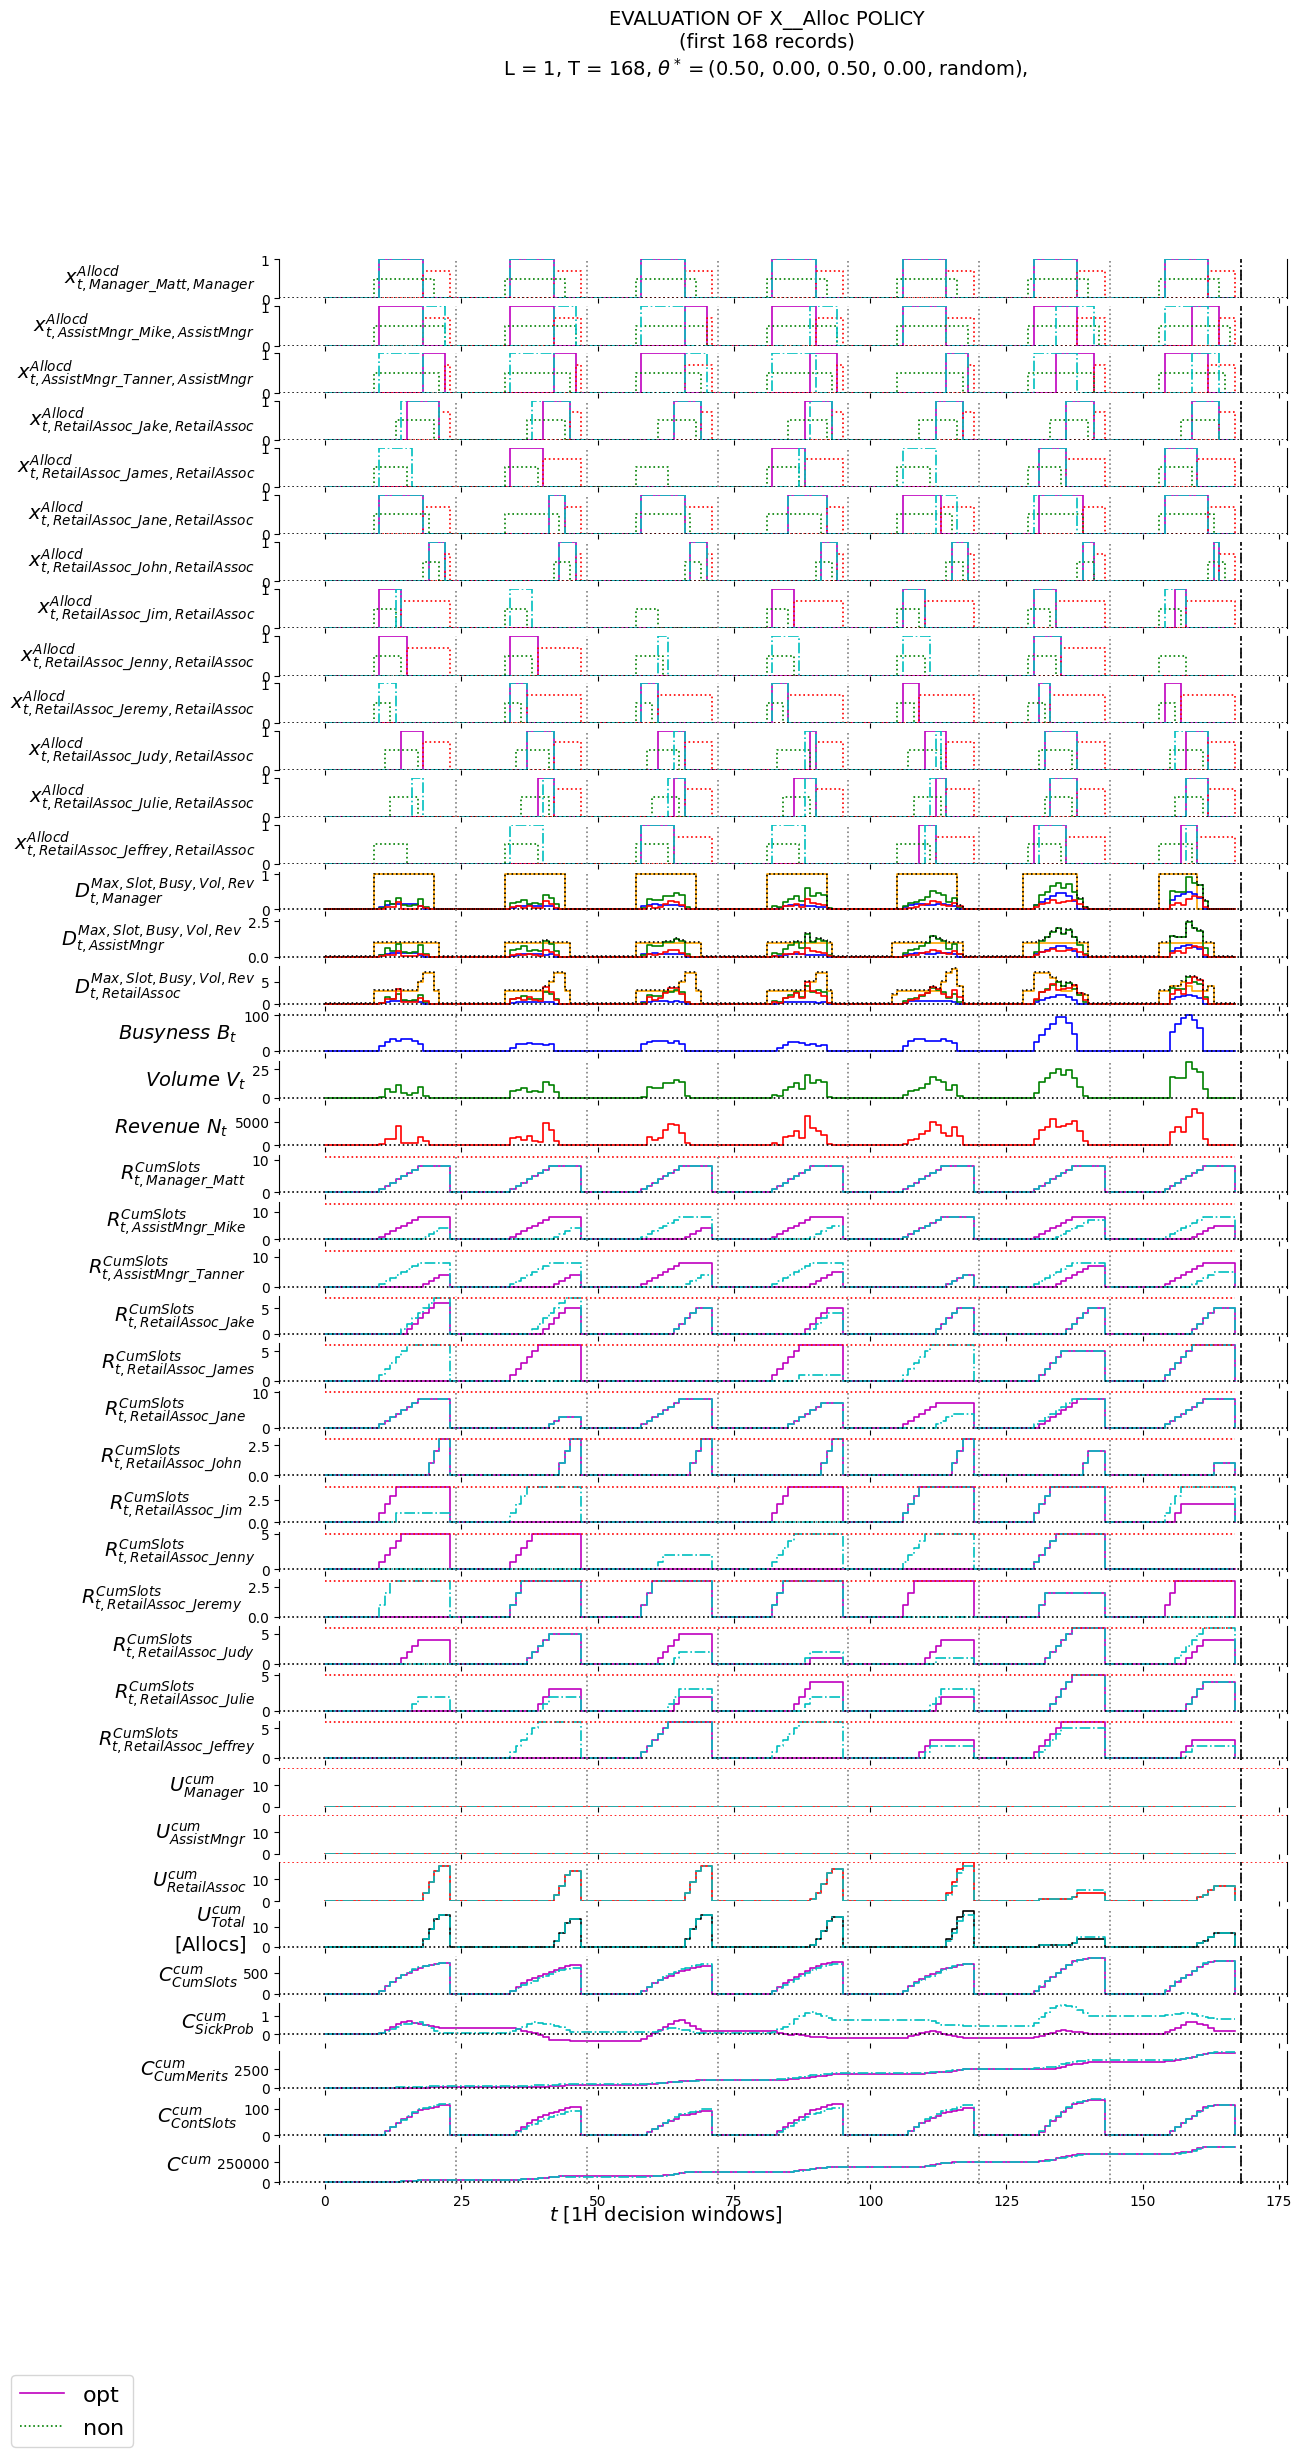

In [66]:
V.plot_records(
  Pars,
  df=Df_evalu_opt,
  df_non=Df_evalu_non, 
  ## df_non=None,
  pars=defaultdict(str, {
    'T': T,
    'thCumSlots': Best_theta_evalu_opt.thCumSlots,
    'thSickProb': Best_theta_evalu_opt.thSickProb,
    'thCumSlotsNon': Best_theta_evalu_non.thCumSlots,
    'thSickProbNon': Best_theta_evalu_non.thSickProb,
    'legendLabels': [r'$\mathrm{opt}$', r'$\mathrm{non}$'],
    'xlabel': "$t\ \mathrm{["+f"{Pars.DATE_TIME_DELTA}"+"\ decision\ windows]}$",
    'suptitle': f'EVALUATION OF X__Alloc POLICY'+'\n'+f'(first {First_n_t} records)'+'\n'+ \
    f'L = {L}, T = {T}, '+ \
    r"$\theta^* =$("+ \
      str(f'{Best_theta_evalu_opt[0]:,.2f}')+", "+ \
      str(f'{Best_theta_evalu_opt[1]:,.2f}')+", "+ \
      str(f'{Best_theta_evalu_opt[2]:,.2f}')+", "+ \
      str(f'{Best_theta_evalu_opt[3]:,.2f}')+", "+
      f'{Best_theta_evalu_opt[4]}'+"), " \
  }),
)

In [67]:
if 'EVALU' in cf.MODES:
  print(Df_evalu_opt[Df_evalu_opt['t']==T-1][['Ccum']])

            Ccum
167 447,927.3300


In [68]:
if 'EVALU' in cf.MODES:
  print(Df_evalu_non[Df_evalu_non['t']==T-1][['Ccum']])

            Ccum
167 443,322.2575


From the `Ccum` plot we see that the cumulative reward for the optimal policy keeps on rising. The non-optimal policy does not do as well.

#### 4.6.3 Comparison of Optimized Policies

In [69]:
## hide
## P.plot_evalu_comparison(
#   df1=df_BuyBelow_evalu_opt,
#   df2=df_Bellman_evalu_opt,
#   df3=None,
#   pars= defaultdict(str, {
#     'suptitle': f'EVALUATION OF ALL POLICIES (first {first_n_t} records)\n \
#     L={L}, T={T}',
#   }),
# )

## 5 EVALUATION

In [70]:
##
if 'EVALU' in cf.MODES:
  utl.print_schedule_shifts(Df_evalu_opt, Pars)

SCHEDULE SHIFTS:

************** Manager_Matt:
Mon Dec 04 09h00
Mon Dec 04 17h00

Tue Dec 05 09h00
Tue Dec 05 17h00

Wed Dec 06 09h00
Wed Dec 06 17h00

Thu Dec 07 09h00
Thu Dec 07 17h00

Fri Dec 08 09h00
Fri Dec 08 17h00

Sat Dec 09 09h00
Sat Dec 09 17h00

Sun Dec 10 09h00
Sun Dec 10 17h00

************** AssistMngr_Mike:
Mon Dec 04 09h00
Mon Dec 04 17h00

Tue Dec 05 09h00
Tue Dec 05 17h00

Wed Dec 06 17h00
Wed Dec 06 21h00

Thu Dec 07 09h00
Thu Dec 07 17h00

Fri Dec 08 09h00
Fri Dec 08 17h00

Sat Dec 09 09h00
Sat Dec 09 17h00

Sun Dec 10 14h00
Sun Dec 10 19h00

************** AssistMngr_Tanner:
Mon Dec 04 17h00
Mon Dec 04 21h00

Tue Dec 05 17h00
Tue Dec 05 21h00

Wed Dec 06 09h00
Wed Dec 06 17h00

Thu Dec 07 16h00
Thu Dec 07 21h00

Fri Dec 08 17h00
Fri Dec 08 21h00

Sat Dec 09 13h00
Sat Dec 09 20h00

Sun Dec 10 09h00
Sun Dec 10 17h00

************** RetailAssoc_Jake:
Mon Dec 04 14h00
Mon Dec 04 20h00

Tue Dec 05 15h00
Tue Dec 05 20h00

Wed Dec 06 15h00
Wed Dec 06 20h00

Thu Dec 07 15h

In [71]:
##
if 'EVALU' in cf.MODES:
  utl.print_schedule_slots(Df_evalu_opt, Pars)

SCHEDULE SLOTS:

************** Manager_Matt:

Mon Dec 04 09h00
Mon Dec 04 10h00
Mon Dec 04 11h00
Mon Dec 04 12h00
Mon Dec 04 13h00
Mon Dec 04 14h00
Mon Dec 04 15h00
Mon Dec 04 16h00

Tue Dec 05 09h00
Tue Dec 05 10h00
Tue Dec 05 11h00
Tue Dec 05 12h00
Tue Dec 05 13h00
Tue Dec 05 14h00
Tue Dec 05 15h00
Tue Dec 05 16h00

Wed Dec 06 09h00
Wed Dec 06 10h00
Wed Dec 06 11h00
Wed Dec 06 12h00
Wed Dec 06 13h00
Wed Dec 06 14h00
Wed Dec 06 15h00
Wed Dec 06 16h00

Thu Dec 07 09h00
Thu Dec 07 10h00
Thu Dec 07 11h00
Thu Dec 07 12h00
Thu Dec 07 13h00
Thu Dec 07 14h00
Thu Dec 07 15h00
Thu Dec 07 16h00

Fri Dec 08 09h00
Fri Dec 08 10h00
Fri Dec 08 11h00
Fri Dec 08 12h00
Fri Dec 08 13h00
Fri Dec 08 14h00
Fri Dec 08 15h00
Fri Dec 08 16h00

Sat Dec 09 09h00
Sat Dec 09 10h00
Sat Dec 09 11h00
Sat Dec 09 12h00
Sat Dec 09 13h00
Sat Dec 09 14h00
Sat Dec 09 15h00
Sat Dec 09 16h00

Sun Dec 10 09h00
Sun Dec 10 10h00
Sun Dec 10 11h00
Sun Dec 10 12h00
Sun Dec 10 13h00
Sun Dec 10 14h00
Sun Dec 10 15h00
Sun Dec 10 1

## 6 DEPLOYMENT | INFERENCE
Please see `production` module.

In [74]:
#| hide
import nbdev; nbdev.nbdev_export()

/Users/kobus/aishiftscheduler/aishiftscheduler/shift_scheduler_data.xlsx
/Users/kobus/aishiftscheduler/aishiftscheduler/AIShiftScheduler1.png

len(thNAMES)=5
thNAMES=['thCumSlots', 'thSickProb', 'thCumMerits', 'thContSlots', 'thSelect']
